# <span style="color:blue"> MBA em Ciência de Dados</span>
# <span style="color:blue">Estatística</span>

## <span style="color:blue">Avaliação Final</span>
**Mariana Cúri**<br>

**Cemeai - ICMC/USP São Carlos**

<span style="color:green"><strong>Prova realizada por Arion Melkan de Freitas</strong></span>

Os dados do arquivo Brain, em anexo, referem-se ao peso do cérebro (g), tamanho da cabeça (cm3) de 237 adultos, identificados por sexo e grupo etário. O estudo teve por objetivo verificar se: <br>

1) Há diferença no peso cerebral entre os sexos? E entre os grupos etários?  <br>

2) O tamanho da cabeça é preditor do peso cerebral e, neste caso, há diferença nessa relação entre os sexos e entre os grupos etários?  <br>

3) Estime o peso médio do cérebro de homens e de mulheres (pontual e intervalar).  <br>

Interprete seus resultados e verifique se as suposições dos métodos são adequadas a estes dados.  <br>

Se uma das suas respostas (aos itens 1, 2 ou 3) aplicar, além da estatística clássica, também a bayesiana (de maneira adequada, claro), sua nota será acrescida de 1 ponto (ou seja, sua prova fica valendo 11 pontos).  <br>

O formato de entrega será de dois arquivos:  <br>

<span style='color:black'><ul><li>1 PDF, com os resultados resumidos e comentados e outro em Jupyter Notebook, com os códigos usados para a obtenção dos resultados. </li>
<li>Este notebook, deve ser comentado de forma a facilmente identificar os códigos de cada análise.</li></ul> </span>

In [1]:
# Importando as bibliotecas necessárias
import pandas as pd
import numpy as np
import pymc3 as pm
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.formula.api import ols
from scipy.stats import beta, norm, levene, pearsonr, linregress, probplot, normaltest, anderson, fligner, bartlett
from scipy.stats import shapiro, chi2_contingency, mannwhitneyu, ttest_ind, median_test, t, sem, zscore, bayes_mvs
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.api import OLS, add_constant, graphics
from statsmodels.stats.api import DescrStatsW
from statsmodels.tools.eval_measures import rmse
from math import sqrt
from functools import reduce
from patsy import dmatrices

sns.set()

WARNING (theano.configdefaults): g++ not available, if using conda: `conda install m2w64-toolchain`
C:\Users\Arion\Anaconda3\lib\site-packages\theano\configdefaults.py:560: UserWarning: DeprecationWarning: there is no c++ compiler.This is deprecated and with Theano 0.11 a c++ compiler will be mandatory
  warnings.warn("DeprecationWarning: there is no c++ compiler."
WARNING (theano.configdefaults): g++ not detected ! Theano will be unable to execute optimized C-implementations (for both CPU and GPU) and will default to Python implementations. Performance will be severely degraded. To remove this warning, set Theano flags cxx to an empty string.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
# print da versão do pymc3
print('Running on PyMC3 v{}'.format(pm.__version__))

Running on PyMC3 v3.8


<span style='color:black'>Nessa primeira etapa, eu definirei alguns métodos para não precisar duplicar o código nas duas questões da primeira questão e, por acaso, utilize algum método posteriormente na segunda e terceira questão.</span>

In [3]:
# Método que exibi os valores únicos de cada atributo
def unique_values(df, attribute):
    print(df[attribute].unique())

In [4]:
# Definição do método que exibirá o pairplot das variáveis do dataframe com correlação com o atributo escolhido
def show_pairplot(df, attribute):
    sns.pairplot(df, hue = attribute);

In [5]:
# Neste método eu defino para exibir as funções de contador, média, mediana e desvio padrão 
# do conjunto de atributos selecionados
def show_aggfunc(df, x, indx):
    return df.pivot_table(values = x, index = indx, aggfunc=['count', 'mean', 'median', 'std', 'min', 'max'])

In [6]:
# Método para exibição do boxplot
def show_boxplot(df, col_hm, col_pes):
    y = df[col_hm]
    x = df[col_pes]

    sns.boxplot(y=y, x=x, palette='Blues');

In [7]:
# Definindo o método que exibe o probplot
def show_probplot(mps, hps, msg_1, msg_2):
    
    # Gráficos de probabilidade da Normal, para checar suposição de tal distribuição dos dados
    plt.figure(figsize=(11, 4))

    plt.subplot(1, 2, 1)
    probplot(mps, plot=plt)
    plt.title(msg_1)

    plt.xlabel('quantis teóricos')
    plt.ylabel('valores ordenados da variável')

    plt.subplot(1, 2, 2)
    probplot(hps, plot=plt)
    plt.title(msg_2)

    plt.xlabel('quantis teóricos')
    plt.ylabel('valores ordenados da variável')
    plt.show()

In [8]:
# Método traz o resultado das duas caudas
def alpha_bicaudal(alpha):
    # Eu defini uma hipótese alternativa sendo diferente, portanto me leva a uma situação bicaudal, por isso vou dividir
    # o alpha
    regiao_critica = alpha / 2
    
    # Cauda do lado direito
    cauda_d = regiao_critica
    
    # Cauda do lado esquerdo
    cauda_e = (95 / 100) + regiao_critica
    
    return cauda_d, cauda_e

In [9]:
# Criei um método para comparar o p_valor retornado dos métodos que comparam se a amostra segue uma normal
# Defini o parâmetro alpha com o nível de significância igual a 5%
def is_normal(p, alpha = 5e-2):

    ident = 4 * ' '
    
    if p > alpha:
        print(f'{ident}O p_valor, {p:.4f}, é maior em relação ao nível de significância {alpha}'
              f'\n{ident}Aceitando a hipótese nula - (Amostra é igual estatisticamente a uma distribuição normal)')
    elif p < alpha:
        print(f'{ident}O p_valor, {p:4f}, é menor em relação ao nível de siginificância {alpha}.'
              f'\n{ident}Rejeitando a hipótese nula - (Amostra não é igual estatisticamente a uma distribuição normal)')
    else:
        print(f'{ident}O p_valor, {p:4f}, é igual ao nível de siginificância {alpha}.'
              f'\n{ident}Mesmo sendo igual ao nível de significância.'
              f'\n{ident}Rejeitando a hipótese nula - (Amostra não é igual estatisticamente a uma distribuição normal)')
        
# Criando o método que chamará o método is_normal - Para evitar duplicidade de código
def show_message_is_normal(msg_1, msg_2, p_m, p_h):
    print(f'Cenário: {msg_1}')
    is_normal(p_m)
    
    print(f'\nCenário: {msg_2}')
    is_normal(p_h)

In [10]:
# Método para exibir o resultado do método anderson_darling
def show_result_anderson_darling(p_value):
    
    for i in range(len(p_value.critical_values)):
        sl, cv = p_value.significance_level[i], p_value.critical_values[i]
          
        if p_value.statistic < cv:
            print(f'Possivelmente normal (Gaussiana) com o nível de significância {sl:.1f}%')
        else:
            print(f'Possivelmente não normal (não Gaussiana) com o nível de siginificância {sl:.1f}%')

In [11]:
# Método para exibir os testes de igualdade ou não das variâncias, os testes de igualdade ou não das médias e os testes
# de igualdade ou não das medianas
# alpha igual a 0.05
def show_result_variance_mean_median(stats, p_value, alpha = 5e-2, message = ''):
    print(f'O valor da estatística do teste: {stats}\nO valor do p_valor: {p_value}')
    
    # Chamando o método de buscar os resultados de significância da cauda da direita e da esquerda
    cauda_d, cauda_e = alpha_bicaudal(alpha)
    
    # Condição para comparar estatística do teste com a região crítica
    if stats > cauda_d and stats < cauda_e:
        print(f'\nA estatística de teste, {stats:.3f}, não está na região critíca.'
              f'\nCauda da direta: {cauda_d:.4f} e Cauda da esquerda: {cauda_e:.4f}'
              f'\nAceitando a hipótese nula. (A {message} das duas amostras são iguais estatisticamente)')
    elif stats <= cauda_d:
        print(f'\nA estatística de teste, {stats}, está na região crítica.' 
              f'\nA estatística de teste, {stats}, se encontra na região da cauda da direita, {cauda_d}'
              f'\nRejeitando a hipótese nula. (A {message} das duas amostras não são iguais estatisticamente)') 
    else:
        print(f'\nA estatística de teste, {stats}, está na região crítica.' 
              f'\nA estatística de teste, {stats}, se encontra na região da cauda da esquerda, {cauda_e}'
              f'\nRejeitando a hipótese nula. (A {message} das duas amostras não são iguais estatisticamente)')
    
    # Condição para comparar o p_valor com o nível de significância
    if p_value > alpha:
        print(f'\nO p_valor, {p_value:.3f}, é maior em relação ao nível de siginificância, {alpha}'
              f'\nAceitando a hipótese nula. (A {message} das duas amostras são iguais estatisticamente)')
    elif p_value < alpha:
        print(f'\nO p_valor, {p_value}, é menor em relação ao nível de siginificância, {alpha}'
              f'\nRejeitando a hipótese nula. (A {message} das duas amostras não são iguais estatisticamente)')
    else:
        print(f'\nO p_valor, {p_value}, é igual ao nível de siginificância, {alpha}' 
              f'\nMesmo o p_valor sendo igual ao nível de significância.'
              f'\nRejeitando a hipótese nula. (A {message} das duas amostras não são iguais estatisticamente)')
        

In [12]:
# Método para exibir o teste se as duas amostras são diferentes ou não
# alpha igual a 0.05
def show_result_mwu(stats, p_value, alpha = 5e-2):
    print(f'O valor da estatística do teste: {stats}\nO valor do p_valor: {p_value}')

    # Chamando o método de buscar os resultados de significância da cauda da direita e da esquerda
    cauda_d, cauda_e = alpha_bicaudal(alpha)
    
    # Condição para comparar estatística do teste com a região crítica
    if stats > cauda_d and stats < cauda_e:
        print(f'\A estatística de teste, {stats:.3f}, não está na região critíca.'
              f'\nCauda da direta: {cauda_d:.4f} e Cauda da esquerda: {cauda_e:.4f}'
              f'\nAceitando a hipótese nula. (Amostras parecidas)')
    elif stats <= cauda_d:
        print(f'\nA estatística de teste, {stats}, está na região crítica.'
              f'\nA estatística de teste, {stats}, se encontra na região da cauda da direita, {cauda_d}'
              f'\nRejeitando a hipótese nula. (Amostras diferentes)')
    else:
        print(f'\nA estatística de teste, {stats}, está na região crítica.' 
              f'\nA estatística de teste, {stats}, se encontra na região da cauda da esquerda, {cauda_e}'
              f'\nRejeitando a hipótese nula. (Amostras diferentes)')

    # Condição para comparar o p_valor com o nível de significância
    if p_value > alpha:
        print(f'\nO p_valor, {p_value}, é maior em relação ao nível de siginificância, {alpha}'
              f'\nAceitando a hipótese nula. (Amostras parecidas)')
    elif p_value < alpha:
        print(f'\nO p_valor, {p_value}, é menor em relação ao nível de siginificância, {alpha}'
              f'\nRejeitando a hipótese nula. (Amostras diferentes)')
    else:
        print(f'\nO p_valor, {p_value}, é igual ao nível de siginificância, {alpha}'
              f'\nMesmo o p_valor sendo igual ao nível de significância.'
              f'\nRejeitando a hipótese nula. (Amostras diferentes)')

In [13]:
# Escrevi as funções em lambda para facilitar - Funções com objetivo de testes de normalidade
# Método shapiro - devolve a estatística do teste e o p_valor - Identificar se a amostra segue uma distribuição normal
f_shapiro = lambda x: shapiro(x)

# Método D'Agostino - devolve a estatística do teste e o p_valor - Identificar se a amostra segue uma distribuição normal
f_agostino = lambda x: normaltest(x)

# Método Anderson Darling - devolve a estatística do teste e o p_valor - Identificar se a amostra segue uma distribuição normal
f_anderson_darling = lambda x: anderson(x)

In [14]:
# Escrevi as funções em lambda para facilitar - Funções com objetivo de testes da variância
# Método levene - devolve a estatística do teste e o p_valor - Identificar se duas amostras possuem mesma variância
f_levene = lambda x, y: levene(x, y)

# Método bartlett - devolve a estatística do teste e o p_valor - Identificar se duas amostras possuem mesma variância
f_bartlett = lambda x, y: bartlett(x, y)

# Método fligner - devolve a estatística do teste e o p_valor - Identificar se duas amostras possuem mesma variância
f_fligner = lambda x, y: fligner(x, y)

In [15]:
# Escrevi as funções em lambda para facilitar - Função com objetivo de teste da média
# Método T - Student - devolve a estatística do teste e o p_valor - Identificar se duas amostras possuem a mesma média com
# variâncias iguais
f_t_student = lambda x, y: ttest_ind(x, y)

In [16]:
# Escrevi as funções em lambda para facilitar - Função com objetivo de teste da mediana
# Método Median_test - devolve a estatística do teste, o p_valor, a mediana e o array de contingência
# Identificar se duas amostras possuem a mesma mediana
f_median_t = lambda x, y: median_test(x, y)

In [17]:
# Escrevi as funções em lambda para facilitar - Função com objetivo de teste se as amostras possuem medianas diferentes
# Mann whitney - devolve a estatística do teste e o p_valor - Identificar se duas amostras possuem medianas diferentes
f_mann_whitney_u = lambda x, y: mannwhitneyu(x, y, alternative='two-sided')

In [18]:
# Função em lambda para definir um array com os resultados dos grupos
f_def_array = lambda x: np.array([min(x), max(x)])

In [19]:
# Função em lambda para definir o intervalo de confiança do cenário bicaudal 
# - Intervalo de confiança para média (variância conhecida)
f_def_n_ic = lambda x, y, z: norm.interval(x, loc = y, scale = z)

# - Intervalo de confiança para média (variância desconhecida) - Utilizando t student
f_def_t_ic = lambda x, y, w, z: t.interval(x, y, loc = w, scale = z)

# - Intervalo de confiança para média (variância desconhecida) - DWS
f_def_dws_ic = lambda x: DescrStatsW(x).tconfint_mean(alternative='two-sided')

In [20]:
# Função em lambda para o cálculo do desvio padrão populacional divido pela raiz quadrada do tamanho da amostra
# Chamarei a função de f_c_dpp_amst
f_c_dpp_amst = lambda x, y:  x / sqrt(len(y)) # f_c_dpp_amst = lambda x, y: np.std(x) / sqrt(y) - outro jeito de fazer

In [21]:
# Função de obter o log de likelihood da normal
f_get_ll_normal = lambda x, mu, sigma: np.sum(np.log(norm.pdf(x, mu, sigma)))

In [22]:
# Função para plotar, olhando o modelo de regressão linear para esse caso, os dados dos grupos
f_get_plot_dff_gropus = lambda x, y, z, w, lst_color: sns.lmplot(x = x, y = y, hue = z, data = w, palette = lst_color, 
                                                                 height = 6)

In [23]:
# Método que plota uma distribuição normal
def plot_normal_distribution(arr_m_h, media_m, dp_m, media_h, dp_h, msg_a, msg_b, lst_num, ic_m, ic_h, text):
    # Normal
    x = np.linspace(min(arr_m_h) - lst_num[0], max(arr_m_h) + lst_num[1], 300)
    
    pdf_1 = norm.pdf(x, media_m, dp_m)
    pdf_2 = norm.pdf(x, media_h, dp_h)
    
    plt.figure(figsize=(10,6))
    
    plt.plot(x, pdf_1, label=f'{msg_a} = f(x);' r'$\bar X$' f'={media_m:.2f},S={dp_m:.2f}', color='red')
    plt.plot(x, pdf_2, label=f'{msg_b} = f(x);' r'$\bar X$' f'={media_h:.2f},S={dp_h:.2f}', color='purple')
    
    #plt.fill_between(x, pdf_1, where = [i < rgc_m[0] or i > rgc_m[1] for i in x], color='orange', alpha = 0.2)
    #plt.fill_between(x, pdf_2, where = [i < rgc_h[0] or i > rgc_h[1] for i in x], color='blue', alpha = 0.2)
    
    plt.xlabel(text)
    plt.ylabel('Valores da Probablidade da Função de Densidade - Normal')
    plt.legend();

In [24]:
# Compara a verossimilhança da amostra para diferentes valores dos parâmetros mu
def L_amostra(x, mu, sd):
    L = 0
    for i in x:
        L += norm.pdf(i, mu, sd) # cálculo da função de verossimilhança da amostra
        
    return L

In [25]:
# Este método serve para exibir o resultado do intervalo de confiança das amostras mais a média
def show_confidence_int_mean(msg_a, msg_b, rgc_a, rgc_b, media_a, media_b):
    print(f'O intervalo de confiança para {msg_a} são: {rgc_a[0]:.4f} e {rgc_a[1]:.4f} - A média é = {media_a:.4f}')
    print(f'O intervalo de confiança para {msg_b} são: {rgc_b[0]:.4f} e {rgc_b[1]:.4f} - A média é = {media_b:.4f}')

In [26]:
# Método que plota o gráfico com a melhor média através do estimador de máxima verossimilhança
def show_plot_mv(theta, f_theta1, dp_a, ident = 3 * ' '):
    
    i_best = np.argmax(f_theta1) # cálculo (numérico) do estimador de máxima verossimilhança (EMV) de mu
    
    print(f'{ident}Melhor mu: {theta[i_best]:.4f}')

    plt.plot(theta, f_theta1, label = f'$S={dp_a:.4f}$')
    plt.plot([theta[i_best]], [f_theta1[i_best]], 'r*') # coloca uma estrela no maior valor (EMV)
    plt.legend()

In [27]:
# Método que retorna o modelo OLS e exibi um resumo
def execute_ols(form, df):   
    mod = ols(form, data = df)
    res = mod.fit()
    
    print(res.summary())
    
    return res

In [28]:
# Método que executará o VIF - Variance Inflation Factor
def execute_vif(form, df):
    # Cálculo do VIF (fator de inflação de variação)
    # Gerar uma matriz de experimento adequada para a regressão.
    
    y, X = dmatrices(form, df, return_type='dataframe')

    # Para cada X, calcular VIF e seu resultado salvar no dataframe - vif
    vif = pd.DataFrame()
    vif["VIF Factor"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    vif["Features"] = X.columns
    
    return vif

In [29]:
# Método que realiza o processo de foward regression
def forward_regression(X, y, threshold_in, verbose=False):
    
    initial_list = []
    included = list(initial_list)
    
    while True:
        changed=False
        excluded = list(set(X.columns)-set(included))
        new_pval = pd.Series(index=excluded)
        
        for new_column in excluded:
            model = OLS(y, add_constant(pd.DataFrame(X[included+[new_column]]))).fit()
            new_pval[new_column] = model.pvalues[new_column]
        
        best_pval = new_pval.min()
        
        if best_pval < threshold_in:
            best_feature = new_pval.idxmin()
            included.append(best_feature)
            changed=True
            
            if verbose:
                print('Add  {:30} with p-value {:.6}'.format(best_feature, best_pval))

        if not changed:
            break

    return included

In [30]:
# Método que realiza o processo de backward regression
def backward_regression(X, y, threshold_out, verbose=False):
    
    included=list(X.columns)
    
    while True:
        changed=False
        model = OLS(y, add_constant(pd.DataFrame(X[included]))).fit()
        # use all coefs except intercept
        pvalues = model.pvalues.iloc[1:]
        worst_pval = pvalues.max() # null if pvalues is empty
        
        if worst_pval > threshold_out:
            changed=True
            worst_feature = pvalues.idxmax()
            included.remove(worst_feature)
        
            if verbose:
                print('Drop {:30} with p-value {:.6}'.format(worst_feature, worst_pval))
        
        if not changed:
            break
            
    return included

In [31]:
# Processos para a geração do stepwise
def BidirectionalStepwiseSelection(X, y, model_type ="linear", elimination_criteria = "aic", varchar_process = "dummy_dropfirst", senter=0.05, sstay=0.05):
    
    """
    Forward Selection is a function, based on regression models, that returns significant features and selection iterations.\n
    Required Libraries: pandas, numpy, statmodels
    
    Parameters
    ----------
    X : Independent variables (Pandas Dataframe)\n
    y : Dependent variable (Pandas Series, Pandas Dataframe)\n
    model_type : 'linear' or 'logistic'\n
    elimination_criteria : 'aic', 'bic', 'r2', 'adjr2' or None\n
        'aic' refers Akaike information criterion\n
        'bic' refers Bayesian information criterion\n
        'r2' refers R-squared (Only works on linear model type)\n
        'r2' refers Adjusted R-squared (Only works on linear model type)\n
    varchar_process : 'drop', 'dummy' or 'dummy_dropfirst'\n
        'drop' drops varchar features\n
        'dummy' creates dummies for all levels of all varchars\n
        'dummy_dropfirst' creates dummies for all levels of all varchars, and drops first levels\n
    senter : Significance Level to be Selected in Forward Selection (default: 0.05)\n
    sstay : Significance Level to be Stayed in Backward Elimination (default: 0.05)\n
  
    Returns
    -------
    columns(list), iteration_logs(str)\n\n
    Not Returns a Model
    
    Tested On
    ---------
    Python v3.6.7, Pandas v0.23.4, Numpy v1.15.04, StatModels v0.9.0
    
    See Also
    --------
    https://en.wikipedia.org/wiki/Stepwise_regression
    """  
    
    X = __varcharProcessing__(X,varchar_process = varchar_process)
    return __stepwiseSelectionRaw__(X, y, model_type = model_type,elimination_criteria = elimination_criteria , senter = senter, sstay = sstay)

def __varcharProcessing__(X, varchar_process = "dummy_dropfirst"):
    
    dtypes = X.dtypes
    if varchar_process == "drop":   
        X = X.drop(columns = dtypes[dtypes == np.object].index.tolist())
        print("Character Variables (Dropped):", dtypes[dtypes == np.object].index.tolist())
    elif varchar_process == "dummy":
        X = pd.get_dummies(X,drop_first=False)
        print("Character Variables (Dummies Generated):", dtypes[dtypes == np.object].index.tolist())
    elif varchar_process == "dummy_dropfirst":
        X = pd.get_dummies(X,drop_first=True)
        print("Character Variables (Dummies Generated, First Dummies Dropped):", dtypes[dtypes == np.object].index.tolist())
    else: 
        X = pd.get_dummies(X,drop_first=True)
        print("Character Variables (Dummies Generated, First Dummies Dropped):", dtypes[dtypes == np.object].index.tolist())
    
    X["intercept"] = 1
    cols = X.columns.tolist()
    cols = cols[-1:] + cols[:-1]
    X = X[cols]
    
    return X

def __stepwiseSelectionRaw__(X, y, model_type ="linear",elimination_criteria = "aic", senter=0.05, sstay=0.05):

    iterations_log = ""
    cols = X.columns.tolist()
    
    def regressor(y,X, model_type=model_type):
        if model_type == "linear":
            regressor = OLS(y, X).fit()
        elif model_type == "logistic":
            regressor = Logit(y, X).fit()
        else:
            print("\nWrong Model Type : "+ model_type +"\nLinear model type is seleted.")
            model_type = "linear"
            regressor = OLS(y, X).fit()
        return regressor
    
    selected_cols = ["intercept"]
    other_cols = cols.copy()
    other_cols.remove("intercept")
    
    model = regressor(y, X[selected_cols])
    
    if elimination_criteria == "aic":
        criteria = model.aic
    elif elimination_criteria == "bic":
        criteria = model.bic
    elif elimination_criteria == "r2" and model_type =="linear":
        criteria = model.rsquared
    elif elimination_criteria == "adjr2" and model_type =="linear":
        criteria = model.rsquared_adj
    
    
    for i in range(X.shape[1]):
        pvals = pd.DataFrame(columns = ["Cols","Pval"])
        for j in other_cols:
            model = regressor(y, X[selected_cols+[j]])
            pvals = pvals.append(pd.DataFrame([[j, model.pvalues[j]]],columns = ["Cols","Pval"]),ignore_index=True)
        pvals = pvals.sort_values(by = ["Pval"]).reset_index(drop=True)
        pvals = pvals[pvals.Pval<= senter]
        if pvals.shape[0] > 0:
            
            model = regressor(y, X[selected_cols+[pvals["Cols"][0]]])
            iterations_log += "\n" + str(i+1) + ". iteration"
            iterations_log += str("\nEntered : "+pvals["Cols"][0] + "\n")    
            iterations_log += "\n\n"+str(model.summary())+"\nAIC: "+ str(model.aic) + "\nBIC: "+ str(model.bic)+"\n\n"
                    

            for k in range(X[selected_cols+[pvals["Cols"][0]]].shape[1]):
                
                cols_backward = X[selected_cols+[pvals["Cols"][0]]].columns.tolist()
                pvals_backward = pd.DataFrame(columns = ["bw_Cols","bw_Pval"])

 
                for l in cols_backward:
                    pvals_backward = pvals_backward.append(pd.DataFrame([[l, model.pvalues[l]]],columns= ["bw_Cols","bw_Pval"]),ignore_index=True)
                    
                pvals_backward = pvals_backward.sort_values(by = ["bw_Pval"]).reset_index(drop=True)
                pvals_backward_drop = pvals_backward[pvals_backward.bw_Pval > sstay].reset_index(drop=True)

                if pvals_backward_drop.shape[0] > 0:
                    
                    
                    iterations_log += str("\nBackward Step Dropped : "+pvals_backward_drop["bw_Cols"][0] + "\n") 
                        
                    if pvals_backward_drop["bw_Cols"][0] in other_cols:
                        other_cols.remove(pvals_backward_drop["bw_Cols"][0])
                    else:
                        pass    
                    
                    if pvals_backward_drop["bw_Cols"][0] in selected_cols:
                        selected_cols.remove(pvals_backward_drop["bw_Cols"][0])
                    else:
                        pass    
                           
                    model = regressor(y, X[selected_cols+[pvals["Cols"][0]]])
                    iterations_log += "\n\n"+str(model.summary())+"\nAIC: "+ str(model.aic) + "\nBIC: "+ str(model.bic)+"\n\n"     
        
           
                else:
                    print("break : No need to Backward Elimination")
                    break
            
            
            if  elimination_criteria == "aic":
                new_criteria = model.aic
                if new_criteria < criteria:
                    print("Entered :", pvals["Cols"][0], "\tAIC :", model.aic)
                    selected_cols.append(pvals["Cols"][0])
                    other_cols.remove(pvals["Cols"][0])
                    criteria = new_criteria
                else:
                    print("break : Criteria")
                    break
            elif  elimination_criteria == "bic":
                new_criteria = model.bic
                if new_criteria < criteria:
                    print("Entered :", pvals["Cols"][0], "\tBIC :", model.bic)
                    selected_cols.append(pvals["Cols"][0])
                    other_cols.remove(pvals["Cols"][0])
                    criteria = new_criteria
                else:
                    print("break : Criteria")
                    break        
            elif  elimination_criteria == "r2" and model_type =="linear":
                new_criteria = model.rsquared
                if new_criteria > criteria:
                    print("Entered :", pvals["Cols"][0], "\tR2 :", model.rsquared)
                    selected_cols.append(pvals["Cols"][0])
                    other_cols.remove(pvals["Cols"][0])
                    criteria = new_criteria
                else:
                    print("break : Criteria")
                    break           
            elif  elimination_criteria == "adjr2" and model_type =="linear":
                new_criteria = model.rsquared_adj
                if new_criteria > criteria:
                    print("Entered :", pvals["Cols"][0], "\tAdjR2 :", model.rsquared_adj)
                    selected_cols.append(pvals["Cols"][0])
                    other_cols.remove(pvals["Cols"][0])
                    criteria = new_criteria
                else:
                    print("Break : Criteria")
                    break
            else:
                print("Entered :", pvals["Cols"][0])
                selected_cols.append(pvals["Cols"][0])
                other_cols.remove(pvals["Cols"][0])            
            
        else:
            print("Break : Significance Level")
            break
        
    model = regressor(y, X[selected_cols])
    if elimination_criteria == "aic":
        criteria = model.aic
    elif elimination_criteria == "bic":
        criteria = model.bic
    elif elimination_criteria == "r2" and model_type =="linear":
        criteria = model.rsquared
    elif elimination_criteria == "adjr2" and model_type =="linear":
        criteria = model.rsquared_adj
    
    print(model.summary())
    print("AIC: "+str(model.aic))
    print("BIC: "+str(model.bic))
    print("Final Variables:", selected_cols)
    

    iterations_log += "\nFinal Selection and Model Statistics\n"
    
    for m in range(len(selected_cols)):
        iterations_log += "\n" + str(m+1) + str(". Final Variable :  "+ selected_cols[m]) 
           
    iterations_log += "\n\n"+str(model.summary())+"\n\nAIC: "+ str(model.aic) + "\nBIC: "+ str(model.bic)+"\n\n"

    return selected_cols, iterations_log

In [32]:
# Método para executar valores preditos de E(y), reísduo, pontos influentes, diagonal da matriz hat...
def execute_res_ols(res_ols):
    
    # valores preditos de E(Y)
    ypred = res_ols.fittedvalues
    
    # resíduo=observado-ajustado
    residuo = res_ols.resid
    
    # objeto para a análise de pontos influentes
    infl = res_ols.get_influence()
    
    # diagonal da matriz hat
    hii = infl.hat_matrix_diag
    
    # resíduo studentizado (internamente)
    res_stud = infl.resid_studentized_internal
    
    # resíduo studentizado com i-ésima observação deletada (externamente)
    res_stud_del = infl.resid_studentized_external
    
    # DFFITS
    dffits, p_d = infl.dffits
    
    # Distância de Cook
    cook, p_c = infl.cooks_distance
    
    return ypred, residuo, infl, hii, res_stud, res_stud_del, dffits, p_d, cook, p_c 

In [33]:
# Método que elabora o resíduo do observado x ajustado - ypred = res.fittedvalues
def plot_residuals_obs_adj(ypred, residuo):

    plt.scatter(ypred,residuo, color='r')

    plt.hlines(0,xmin=min(ypred),xmax=max(ypred),color='y')
    plt.ylabel("Resíduo (Observado-Ajustado)")
    plt.xlabel(r'$\hat{y}$')

In [34]:
# Método dos resíduos padronizado (dividido por rmse)
def plot_standardized_residuals_rmse(ypred, residuo, rmse_pred):
    # Ecnontrando o desvio padrão do resíduo dividido pelo erro quadrático médio
    std_res = residuo/rmse_pred
    
    plt.scatter(ypred, std_res, color='g')
    
    plt.hlines(0,xmin=min(ypred),xmax=max(ypred),color='purple')
    plt.hlines(-2,xmin=min(ypred),xmax=max(ypred),color='purple',linestyles='dotted')
    plt.hlines(2,xmin=min(ypred),xmax=max(ypred),color='purple',linestyles='dotted')
    
    plt.ylabel("Resíduo Padronizado")
    plt.xlabel(r'$\hat{y}$')

In [35]:
# Método que elabora todos os gráficos dos resíduos
def plot_all_residuals(ypred, residuo, res_stud, res_stud_del):
    fig, (ax1, ax2, ax3) = plt.subplots(3, figsize=(6, 6))
    
    # Resíduo observado - ajustado
    ax1.scatter(ypred, residuo, color='purple')
    ax1.set_ylabel('$y-\hat{y}$')
    ax1.set_title('Resíduos')
    ax1.hlines(0,xmin=min(ypred),xmax=max(ypred),color='b')
    
    # Resíduo Studentizado
    ax2.scatter(ypred, res_stud, color='purple')
    ax2.set_ylabel('Studentizado')
    ax2.hlines(0,xmin=min(ypred),xmax=max(ypred),color='b')
    
    # Resíduo Studentizado - (i)
    ax3.scatter(ypred, res_stud_del, color='purple')
    ax3.set_ylabel('Studentizado -(i)')
    ax3.hlines(0,xmin=min(ypred),xmax=max(ypred),color='b')
    ax3.set_xlabel('$\hat{Y}$')
    
    for ax in fig.get_axes():
        ax.label_outer()

In [36]:
# Método que detecta pontos influentes
def detect_inf_points(df, dffits, cook, hii):
    fig, (ax1, ax2, ax3) = plt.subplots(3, figsize=(6, 6))
    
    ax1.scatter(df.index, dffits, color='red')
    ax1.set_ylabel('DFFITS')
    ax1.set_title('Detecção de pontos influentes')
    
    ax2.scatter(df.index, cook, color='red')
    ax2.set_ylabel('Distância de Cook')
    
    ax3.scatter(df.index, hii, color='red')
    ax3.set_ylabel('$h_{ii}$')
    ax3.set_xlabel('índice')
    
    for ax in fig.get_axes():
        ax.label_outer()

In [37]:
# Método que verifica a influência dos resíduos
def plot_check_residuals(res):
    # Gráficos das influências dos resíduos
    graphics.influence_plot(res)

<span style='color:black'>Fim da construção dos métodos.</span>

<span style='color:black'>Antes de começar a responder as questões, farei o início de uma análise descritiva básica para entender um pouco mais os dados que estou trabalhando.</span>

In [38]:
# Lendo o arquivo brain
df_brain = pd.read_csv('brain.csv')

df_brain.head(10)

Homem  Acima45  Tamanho  Peso
0      1        0     4512  1530
1      1        0     3738  1297
2      1        0     4261  1335
3      1        0     3777  1282
4      1        0     4177  1590
5      1        0     3585  1300
6      1        0     3785  1400
7      1        0     3559  1255
8      1        0     3613  1355
9      1        0     3982  1375

In [39]:
df_brain.describe()

Homem     Acima45      Tamanho         Peso
count  237.000000  237.000000   237.000000   237.000000
mean     0.565401    0.535865  3633.991561  1282.873418
std      0.496753    0.499768   365.261422   120.340446
min      0.000000    0.000000  2720.000000   955.000000
25%      0.000000    0.000000  3389.000000  1207.000000
50%      1.000000    1.000000  3614.000000  1280.000000
75%      1.000000    1.000000  3876.000000  1350.000000
max      1.000000    1.000000  4747.000000  1635.000000

<span style ='color:black'>Percebo que o dataframe gerado possui poucos dados e eu tenho somente, dois atributos numéricos enquanto os outros embora com números aparenta ser um tipo de dado binário (0 e 1).<br>Farei logo adiante essa comprovação.</span>

## Inferência Clássica

<span style='color:black'>As células abaixo conterão a abordagem ao conceito clássico</span>

### Exercício 1

a) Há diferença no peso cerebral entre os sexos? 

<span style='color:black'>Para essa questão, eu estou buscando se há igualdade ou diferença entre os pesos cerebrais.<br>
Antes de continuar a programação, definirei minha hipótese para poder trabalhar em cima e definir se aceito ou rejeito a minha hipótese nula.</span>

#### Hipóteses 

$H_0:p_h=p_m$   (O peso cerebral entre homens e mulheres são iguais)


$H_a:p_h \neq p_m$   (O peso cerebral é diferente entre homens e mulheres)

$\alpha $ = 0,05  (Nível de significância)

In [40]:
# Chamando o método do unique values para identificar quais são os possíveis valores de Homens e Mulheres
attr = 'Homem'

unique_values(df_brain, attr)

[1 0]


<span style='color:black'>São os valores possíveis que o atributo Homem assume.<br>Fiz isso para identificar se realmente era binário.</span>

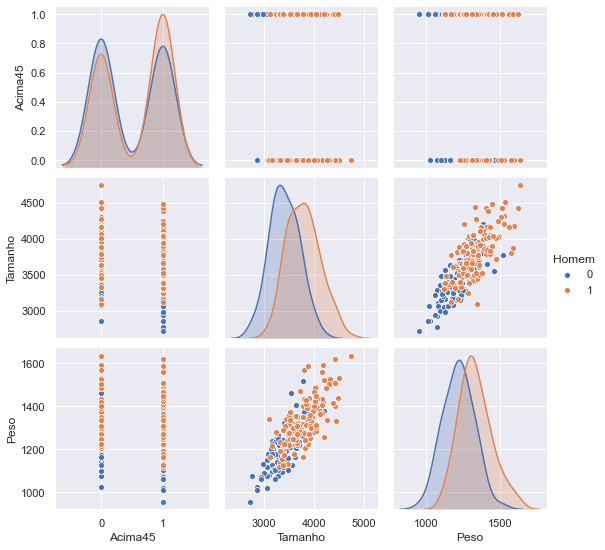

In [41]:
# Chamando o método pairplot do sns para exibir as correlações entre os atributos do dataframe graficamente
# Estou aproveitando e utilizando o atributo da célula acima do parâmetro attr

show_pairplot(df_brain, attr)

<span style='color:black'>Fazendo uma primeira análise, o peso e tamanho possuem diferença, principalmente o tamanho entre os dois grupos do atributo Homem.<br>No decorrer da análise vou confirmar se essa intuição é mesma a correta.</span>

In [42]:
# Chamo o método de exibir as funções do pandas (média, mediana e desvio padrão, por exemplo)
# Inicializo a variável que será o parâmetro x
col_pes = 'Peso'

# Inicializo a variável que será o parâmetro indx
col_hm = 'Homem'

df_tb_pv = show_aggfunc(df_brain, col_pes, col_hm)
df_tb_pv

count         mean  median         std   min   max
       Peso         Peso    Peso        Peso  Peso  Peso
Homem                                                   
0       103  1219.145631  1220.0  103.829933   955  1520
1       134  1331.858209  1313.5  108.933390  1120  1635

<span style = 'color:black'>Aqui tenho uma noção de que os dois grupos tem tamanhos diferentes nas amostras e existe uma diferença considerável na média e na mediana entre os grupos.<br>O desvio padrão também tem diferença entre os grupos, mas um pouco menor em comparação com a média e mediana.</span>

In [43]:
# Para facilitar a interpretação no box plot e em demais métodos que for utilizar, vou criar um campo categórico 
# para homem e mulher a partir do 0 e 1.
# 0 Mulher e 1 Homem
attr_new = 'Genero'

map_genero = {
    0: 'Female',
    1: 'Male'
}

df_brain[attr_new] = df_brain[col_hm].map(map_genero)
df_brain.head()

Homem  Acima45  Tamanho  Peso Genero
0      1        0     4512  1530   Male
1      1        0     3738  1297   Male
2      1        0     4261  1335   Male
3      1        0     3777  1282   Male
4      1        0     4177  1590   Male

<span style='color:black'>Para facilitar em algumas interpretações, criei um novo atributo, Genero, para atribuir 1 para homens e 0 para mulheres.</span>

In [44]:
# Chamando novamente do show aggfunc para exibir com a nova coluna Genero
# Não ocorreu alteração nos valores, apenas eu decidir demonstrar novamente para uma exibição de quais são os valores 0 e 1
col_pes = 'Peso'
col_gen = 'Genero'

df_tb_pv = show_aggfunc(df_brain, col_pes, col_gen)
df_tb_pv

count         mean  median         std   min   max
        Peso         Peso    Peso        Peso  Peso  Peso
Genero                                                   
Female   103  1219.145631  1220.0  103.829933   955  1520
Male     134  1331.858209  1313.5  108.933390  1120  1635

<span style='color:black'>Executei novamente esse passo, mostrando o atributo Genero, para garantir que não houve alteração nos valores das médias, medianas e desvios padrões por exemplo. Após eu criar um novo atributo.</span>

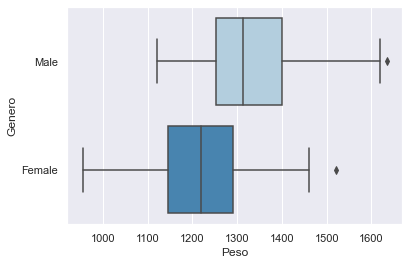

In [45]:
# Aproveitei para utilizar as duas variáveis declaradas na célula acima
show_boxplot(df_brain, col_gen, col_pes)

<span style='color:black'> Para as duas amostras, tenho outliers com valores altos. Vou explorar mais para saber se esses outliers são influentes.</span>

In [46]:
# Estou separando os dados dos dois gêneros, utilizando o novo atributo criado, o Genero.
# Visto nas células anteriores, eu defini Female = 0 e Male = 1
mulheres_peso_cerebral = df_brain.loc[df_brain.Genero == 'Female', 'Peso']
homens_peso_cerebral   = df_brain.loc[df_brain.Genero == 'Male', 'Peso']

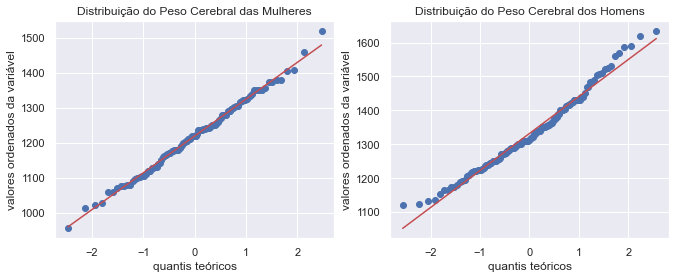

In [47]:
# Vou chamar o método do show_probplot para checar se graficamente os dados se comportam como uma normal
# Utilizo as variáveis da célula acima
mps = mulheres_peso_cerebral
hps = homens_peso_cerebral

msg_1 = 'Distribuição do Peso Cerebral das Mulheres'
msg_2 = 'Distribuição do Peso Cerebral dos Homens'

show_probplot(mps, hps, msg_1, msg_2)

<span style='color:black'>A distribuição do peso cerebral das mulheres se comportou melhor no gráfico em comparação com a distribuição do peso cerebral dos homens, nos quais os extremos fugiram muito da reta teórica e além de no meio fugir um pouco da reta.<br>
Só pelo gráfico não é suficiente para garantir se assemelha a uma distribuição normal ou não. Farei os testes Shapiro-Wilk, D'Agostino e Anderson Darling para identficar se é ou não parecido com uma normal.</span>

In [48]:
# Teste Shapiro-Wilk para identificar se as distribuições são parecidas com a normal ou não.
# Teste do Shapiro somente com os pesos das mulheres
stats_m, p_m = f_shapiro(mulheres_peso_cerebral)

# Teste do Shapiro somente com os pesos dos homens
stats_h, p_h = f_shapiro(homens_peso_cerebral)

ident = 3 * ' '

print(f'O teste de shapiro-wilk para mulheres foi:\n{ident}Valor da estatística do teste = {stats_m} e o p_valor = {p_m}')
print(f'\nO teste de shapiro-wilk para homens foi:\n{ident}Valor da estatística do teste = {stats_h} e o p_valor = {p_h}')

O teste de shapiro-wilk para mulheres foi:
   Valor da estatística do teste = 0.9959982633590698 e o p_valor = 0.9919323921203613

O teste de shapiro-wilk para homens foi:
   Valor da estatística do teste = 0.9780169129371643 e o p_valor = 0.02875436283648014


In [49]:
# Vou chamar o método que eu criei show_message_is_normal, que chama o método is_normal, 
# para comparar com o meu nível de significância. E avaliar as duas amostras se são, aparentementes, normais
show_message_is_normal(msg_1, msg_2, p_m, p_h)

Cenário: Distribuição do Peso Cerebral das Mulheres
    O p_valor, 0.9919, é maior em relação ao nível de significância 0.05
    Aceitando a hipótese nula - (Amostra semelhante a uma distribuição normal)

Cenário: Distribuição do Peso Cerebral dos Homens
    O p_valor, 0.028754, é menor em relação ao nível de siginificância 0.05.
    Rejeitando a hipótese nula - (Amostra diferente a uma distribuição normal)


In [50]:
# Teste D'Agostino para identificar se as distribuições são parecidas com a normal ou não.
# Teste do D'Agostino somente com os pesos das mulheres
stats_mn, p_mn = f_agostino(mulheres_peso_cerebral)

# Teste do D'Agostino somente com os pesos dos homens
stats_hn, p_hn = f_agostino(homens_peso_cerebral)

ident = 3 * ' '

print(f'O teste de D Agostino para mulheres foi:\n{ident}Statistic = {stats_mn} e pvalue = {p_mn}')
print(f'\nO teste de D Agostino para homens foi:\n{ident}Statistic = {stats_hn} e pvalue = {p_hn}')

O teste de D Agostino para mulheres foi:
   Statistic = 0.19372480850260787 e pvalue = 0.9076808905730072

O teste de D Agostino para homens foi:
   Statistic = 5.807578498601639 e pvalue = 0.05481511788278888


In [51]:
show_message_is_normal(msg_1, msg_2, p_mn, p_hn)

Cenário: Distribuição do Peso Cerebral das Mulheres
    O p_valor, 0.9077, é maior em relação ao nível de significância 0.05
    Aceitando a hipótese nula - (Amostra semelhante a uma distribuição normal)

Cenário: Distribuição do Peso Cerebral dos Homens
    O p_valor, 0.0548, é maior em relação ao nível de significância 0.05
    Aceitando a hipótese nula - (Amostra semelhante a uma distribuição normal)


In [52]:
# Teste Anderson-Darling para identificar se as distribuições são parecidas com a normal ou não.
# Teste do Anderson-Darling somente com os pesos das mulheres
p_ma = f_anderson_darling(mulheres_peso_cerebral)

# Exibir o resultado
show_result_anderson_darling(p_ma)

Possivelmente normal (Gaussiana) com o nível de significância 15.0%
Possivelmente normal (Gaussiana) com o nível de significância 10.0%
Possivelmente normal (Gaussiana) com o nível de significância 5.0%
Possivelmente normal (Gaussiana) com o nível de significância 2.5%
Possivelmente normal (Gaussiana) com o nível de significância 1.0%


In [53]:
# Teste do Anderson-Darling somente com os pesos dos homens
p_ha = f_anderson_darling(homens_peso_cerebral)

# Exibir o resultado
show_result_anderson_darling(p_ha)

Possivelmente não normal (não Gaussiana) com o nível de siginificância 15.0%
Possivelmente não normal (não Gaussiana) com o nível de siginificância 10.0%
Possivelmente normal (Gaussiana) com o nível de significância 5.0%
Possivelmente normal (Gaussiana) com o nível de significância 2.5%
Possivelmente normal (Gaussiana) com o nível de significância 1.0%


<span style='color:black'>Após eu passar por 3 métodos diferentes (Shapiro, D'Agostino e Anderson-Darling), concluo que as duas amostras tendem a uma distribuição normal.<br>Nesta análise, eu adotei apenas o nível de significância para rejeitar ou aceitar a hipótese nula, não da questão, mas sim se assemelha uma normal ou não. Vale a atentar que as duas amostras foram avaliadas separadamente.<br> No shapiro, para o grupo dos homens, eu obtive que não se assemelha a uma normal enquanto no Agostino e Anderson Darling foi considerado como normal, considerando o $\alpha = 5$%.</span>

<span style='color:black'>Realizei o teste do qui-quadrado, porém ele serve para identificar se as amostras são independentes a partir de variáveis categóricas, por exemplo: uma variável qualitativa ordinal - alta, média e baixa.<br>O resultado da estatística do teste foi 0 e do p_valor foi 1, não condizendo, pois houve diferença entre os dois.<br><br>Suponho que as amostras sejam independentes, pois verificaremos os pesos cerebrais de diferentes pessoas e em grupos separados, nesse caso entre mulheres e homens.</span>

<span style='color:black'> Aqui começará uma análise prevendo o comportamento da média, mediana e variância dos grupos masculino e feminino, olhando o teste de hipótese bicaudal. O que eu quero dizer é que eu não vou apenas considerar o nível de significância 5% com o p_valor, eu também realizarei a comparação da estatística do teste com as regiões críticas, e embora necessitam chegar na mesma conclusão, faço para consolidar mais as minhas análises e praticar outras respostas para um mesmo problema. 
</span>

In [54]:
# Teste de Levene para igualdade de variâncias
stats_l, p_l = f_levene(mulheres_peso_cerebral, homens_peso_cerebral)

# Método para exibir os testes de igualdade das variâncias
variance = 'variância'
show_result_variance_mean_median(stats_l, p_l, message = variance)

O valor da estatística do teste: 0.08798545130505911
O valor do p_valor: 0.767016022271913

A estatística de teste, 0.088, não está na região critíca.
Cauda da direta: 0.0250 e Cauda da esquerda: 0.9750
Aceitando a hipótese nula. (A variância das duas amostras são semelhantes)

O p_valor, 0.767, é maior em relação ao nível de siginificância, 0.05
Aceitando a hipótese nula. (A variância das duas amostras são semelhantes)


In [55]:
# Teste de Bartlett para igualdade de variâncias
stats_b, p_b = f_bartlett(mulheres_peso_cerebral, homens_peso_cerebral)

# Método para exibir os testes de igualdade das variâncias
# Utilizando da célula acima o parâmetro - variance
show_result_variance_mean_median(stats_b, p_b, message = variance)

O valor da estatística do teste: 0.2634480298522813
O valor do p_valor: 0.6077611464987134

A estatística de teste, 0.263, não está na região critíca.
Cauda da direta: 0.0250 e Cauda da esquerda: 0.9750
Aceitando a hipótese nula. (A variância das duas amostras são semelhantes)

O p_valor, 0.608, é maior em relação ao nível de siginificância, 0.05
Aceitando a hipótese nula. (A variância das duas amostras são semelhantes)


In [56]:
# Teste de Fligner para igualdade de variâncias
stats_f, p_f = f_fligner(mulheres_peso_cerebral, homens_peso_cerebral)

# Método para exibir os testes de igualdade ou a diferença das variâncias
# Utilizando da célula acima o parâmetro - variance
show_result_variance_mean_median(stats_f, p_f, message = variance)

O valor da estatística do teste: 0.07150526846364588
O valor do p_valor: 0.7891575884528079

A estatística de teste, 0.072, não está na região critíca.
Cauda da direta: 0.0250 e Cauda da esquerda: 0.9750
Aceitando a hipótese nula. (A variância das duas amostras são semelhantes)

O p_valor, 0.789, é maior em relação ao nível de siginificância, 0.05
Aceitando a hipótese nula. (A variância das duas amostras são semelhantes)


In [57]:
# Teste t de Student comparando médias entre o peso cerebral dos homens e o peso cerebral das mulheres
stats_ts, p_ts = f_t_student(mulheres_peso_cerebral, homens_peso_cerebral)

# Método para exibir os testes de igualdade ou a diferença das médias
mean = 'média'
show_result_variance_mean_median(stats_ts, p_ts, message = mean)

O valor da estatística do teste: -8.05765147908099
O valor do p_valor: 3.919241152559185e-14

A estatística de teste, -8.05765147908099, está na região crítica.
A estatística de teste, -8.05765147908099, se encontra na região da cauda da direita, 0.025
Rejeitando a hipótese nula. (A média das duas amostras não são semelhantes)

O p_valor, 3.919241152559185e-14, é menor em relação ao nível de siginificância, 0.05
Rejeitando a hipótese nula. (A média das duas amostras não são semelhantes)


In [58]:
# Teste Median_test comparando medianas entre o peso cerebral dos homens e o peso cerebral das mulheres
stats_mt, p_mt, median_mt, arr_mt = f_median_t(mulheres_peso_cerebral, homens_peso_cerebral)

# Método para exibir os testes de igualdade ou a diferença das medianas
median = 'mediana'
show_result_variance_mean_median(stats_mt, p_mt, message = median)

O valor da estatística do teste: 36.078012064707934
O valor do p_valor: 1.8957391258214897e-09

A estatística de teste, 36.078012064707934, está na região crítica.
A estatística de teste, 36.078012064707934, se encontra na região da cauda da esquerda, 0.975
Rejeitando a hipótese nula. (A mediana das duas amostras não são semelhantes)

O p_valor, 1.8957391258214897e-09, é menor em relação ao nível de siginificância, 0.05
Rejeitando a hipótese nula. (A mediana das duas amostras não são semelhantes)


In [59]:
# Teste Mann Whitney U - Comparação com os dois pesos cerebrais, sendo independentes, para identificar se os dois grupos 
# possuem bastante diferença
stats_mw, p_mw = f_mann_whitney_u(mulheres_peso_cerebral, homens_peso_cerebral)

show_result_mwu(stats_mw, p_mw)

O valor da estatística do teste: 3161.0
O valor do p_valor: 8.810232104086761e-13

A estatística de teste, 3161.0, está na região crítica.
A estatística de teste, 3161.0, se encontra na região da cauda da esquerda, 0.975
Rejeitando a hipótese nula. (Amostras diferentes)

O p_valor, 8.810232104086761e-13, é menor em relação ao nível de siginificância, 0.05
Rejeitando a hipótese nula. (Amostras diferentes)


<span style='color:black'>Uma vez que foi identificado que as duas amostras se assemelham a uma distribuição normal e durante as inferências estatísticas a média e a mediana dos grupos foram constatadas que são diferentes.<br>O próximo passo será eu exibir as duas amostras com o comportamento de distribuição normal.</span>

<span style='color:black'>Em relação ao outliers, aparentemente, não foram influentes, pois as médias e as medianas estão próximas, respectivamente ao seu grupo.<br>Concluí, embora tenha outliers, eles não são influentes a ponto de alterarem de forma brusca as médias das amostras.</span>

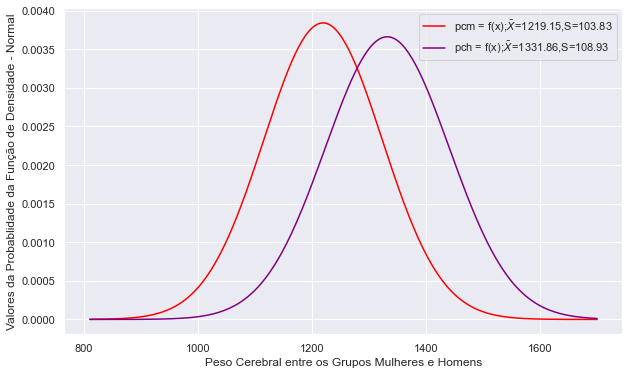

O intervalo de confiança para pcm são: 1198.8532 e 1239.4381 - A média é = 1219.1456
O intervalo de confiança para pch são: 1313.2448 e 1350.4716 - A média é = 1331.8582


In [60]:
# Grupos de mulheres e homens
media_m  = mulheres_peso_cerebral.mean()
media_h  = homens_peso_cerebral.mean()

# Usando o desvio padrão amostral - Considerando com graus de liberdade igual a 1
dp_m_a = mulheres_peso_cerebral.std() # mesmo efeito do np.std(ddof = 1)
dp_h_a = homens_peso_cerebral.std() # mesmo efeito do np.std(ddof = 1)

# Usando o desvio padrão populacional - Considerando com graus de liberdade igual a 0
dp_m_p = mulheres_peso_cerebral.std(ddof = 0) # mesmo efeito do np.std() - ddof = 0
dp_h_p = homens_peso_cerebral.std(ddof = 0) # mesmo efeito do np.std() - ddof = 0

# Desvio padrão populacional do conjunto - Considerando com graus de liberdade igual a 0
dpp   = df_brain[col_pes].std(ddof = 0) # mesmo efeito do np.std() - ddof = 0

# Chamamndo o método do desvio padrão divido pela raiz quadrada do tamanho da amostra
c_dp_m = f_c_dpp_amst(dp_m_a, mulheres_peso_cerebral)
c_dp_h = f_c_dpp_amst(dp_h_a, homens_peso_cerebral)

# Erro padrão da média
epm_m = sem(mulheres_peso_cerebral)
epm_h = sem(homens_peso_cerebral)

# Recuperando o tamanho de cada amostra
tam_n_m = len(mulheres_peso_cerebral)
tam_n_h = len(homens_peso_cerebral)

# Chamando método para criar um array com os valores das mulheres e dos homens
# Aproveitei para utilizar o dataframe com a coluna do Peso, definida nas primeiras células do desenvolvimento dessa questão
arr_m_h = f_def_array(df_brain[col_pes].values)

# Número para ajudar no "layout" da distribuição x - Distribuição de Mulheres e Homens
nmin = 145
nmax = 65

# Será enviado como parâmetro para o método do plot_normal_distribution
lst_num = [nmin, nmax]

# Definições de mensagens
msg_a = 'pcm'
msg_b = 'pch'
text  = 'Peso Cerebral entre os Grupos Mulheres e Homens'

# Definição do alpha
alpha = 0.05

ic = 1 - alpha # Intervalo de confiança

ic_m = f_def_t_ic(ic, tam_n_m - 1, media_m, epm_m) # Definindo o intervalo de confiança do peso cerebral das mulheres
ic_h = f_def_t_ic(ic, tam_n_h - 1, media_h, epm_h) # Definindo o intervalo de confiança do peso cerebral dos homens

# Chamando o método para fazer os gráficos dos pesos entre os grupos mulheres e homens
plot_normal_distribution(arr_m_h, media_m, dp_m_a, media_h, dp_h_a, msg_a, msg_b, lst_num, ic_m, ic_h, text)

# Exibir o gráfico
plt.show()

# Exibir o resultado do intervalo de confiança mais as médias das duas amostras
show_confidence_int_mean(msg_a, msg_b, ic_m, ic_h, media_m, media_h)

<span>Embora seja uma simulação das amostras dispostas em distribuição normal, percebo que existe uma diferença entre os pesos cerebrais de mulheres e homens.<br>Elas possuem uma certa semelhança, mas a do grupo de homens está mais a direita, enquanto o grupo das mulheres a distribuição é mais alta.<br>Aproveitei para adicionar o resultado do intervalo de confiança de cada distribuição.<br><br><br>Concluo, para essa primeira parte da questão, que existe uma diferença do peso cerebral entre homens e mulheres.</span>

<span style='color:blue'>De certa forma, eu respondi um dos pontos da questão 3 - Estimar o peso médio do cerébro entre os grupos de mulheres e homens a partir do estimador intervalar - Nesse caso usei o intervalo de confiança para média (Variância Desconhecida).<br>Eu vou explorar mais os estimadores intervalares na 3ª questão.</span>

### Exercício 1

b) E entre os grupos etários?

#### Hipóteses 

$H_0:p_ab=p_ac$   (O peso cerebral entre abaixo45 e acima45 são iguais)


$H_a:p_ab \neq p_ac$   (O peso cerebral é diferente entre abaixo45 e acima45)

$\alpha $ = 0,05  (Nível de significância)

In [61]:
# Chamando o método do unique values para identificar quais são os possíveis valores do atributo acima45
attr = 'Acima45'

unique_values(df_brain, attr)

[0 1]


<span style='color:black'>São os valores possíveis que o atributo Acima45 assume.<br>Fiz isso para identificar se realmente era binário.</span>

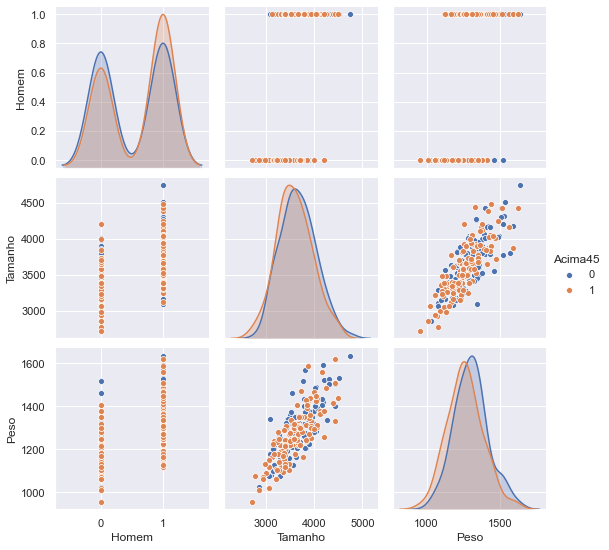

In [62]:
# Chamando o método pairplot do sns para exibir as correlações entre os atributos do dataframe graficamente
# Estou aproveitando e utilizando o atributo da célula acima do parâmetro attr

show_pairplot(df_brain, attr)

<span style='color: black'>Comparandos os pairplot's dos atributos Homem e Acima45, o Acima45 teve mais proximidade entre os grupos etários, são dois na realidade - acima ou não de 45, em relação ao grupo de homens e mulheres.<br>Faz até mais sentido estarem próximos porque o grupo de homens e mulheres agora estão misturados e identifico pela idade.</span>

In [63]:
# Chamo o método de exibir as funções do pandas (média, mediana e desvio padrão, por exemplo)
# Inicializo a variável que será o parâmetro x
col_pes = 'Peso'

# Inicializo a variável que será o parâmetro indx
col_ac = 'Acima45'

df_tb_pv = show_aggfunc(df_brain, col_pes, col_ac)
df_tb_pv

count         mean median         std   min   max
         Peso         Peso   Peso        Peso  Peso  Peso
Acima45                                                  
0         110  1304.736364   1301  116.409959  1027  1635
1         127  1263.937008   1250  120.925712   955  1620

<span style = 'color:black'>Aqui tenho uma noção de que os dois grupos tem tamanhos diferentes nas amostras e existe uma diferença na média e na mediana entre os grupos.<br>O desvio padrão também tem diferença entre os grupos, mas um pouco menor em comparação com a média e mediana. Em relação aos grupos anteriores, Mulheres e Homens, para os grupos Abaixo45 e Acima45 os valores estão um pouco mais próximos.</span>

In [64]:
# Para facilitar a interpretação no box plot e em demais métodos que for utilizar, vou criar um campo categórico 
# para Acima45 e Abaixo45 a partir do 0 e 1.
# 0 Abaixo45 e 1 Acima45
attr_new = 'Idade'

map_genero = {
    0: 'Abaixo45',
    1: 'Acima45'
}

df_brain[attr_new] = df_brain[col_ac].map(map_genero)
df_brain.head()

Homem  Acima45  Tamanho  Peso Genero     Idade
0      1        0     4512  1530   Male  Abaixo45
1      1        0     3738  1297   Male  Abaixo45
2      1        0     4261  1335   Male  Abaixo45
3      1        0     3777  1282   Male  Abaixo45
4      1        0     4177  1590   Male  Abaixo45

<span style='color:black'>Para facilitar em algumas interpretações, criei um novo atributo, Idade, para atribuir 1 para Acima45 e 0 para Abaixo45.</span>

In [65]:
# Chamando novamente do show aggfunc para exibir com a nova coluna Idade
# Não ocorreu alteração nos valores, apenas eu decidir demonstrar novamente para uma exibição de quais são os valores 0 e 1
col_pes = 'Peso'
col_idd = 'Idade'

df_tb_pv = show_aggfunc(df_brain, col_pes, col_idd)
df_tb_pv

count         mean median         std   min   max
          Peso         Peso   Peso        Peso  Peso  Peso
Idade                                                     
Abaixo45   110  1304.736364   1301  116.409959  1027  1635
Acima45    127  1263.937008   1250  120.925712   955  1620

<span style='color:black'>Segui a mesma linha de raciocínio da primeira parte da questão 1.<br>Executei novamente esse passo, mostrando o atributo Idade, para garantir que não houve alteração nos valores das médias, medianas e desvios padrões por exemplo. Após eu criar um novo atributo.</span>

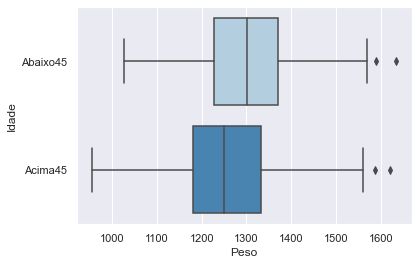

In [66]:
# Aproveitei para utilizar as duas variáveis declaradas na célula acima
show_boxplot(df_brain, col_idd, col_pes)

<span style='color:black'> Para as duas amostras, tenho outliers com valores altos.<br>Em comparação entre os grupos homens e mulheres, os grupos abaixo45 e acima45 possuem um dado a mais, para cada grupo, identificado como outliers.<br>Ao decorrer do notebook explorarei mais essa situação.</span>

In [67]:
# Estou separando os dados dos dois gêneros, utilizando o novo atributo criado, o Genero.
# Visto nas células anteriores, eu defini Abaixo45 = 0 e Acima45 = 1
abaixo45_peso_cerebral = df_brain.loc[df_brain.Idade == 'Abaixo45', 'Peso']
acima45_peso_cerebral  = df_brain.loc[df_brain.Idade == 'Acima45', 'Peso']

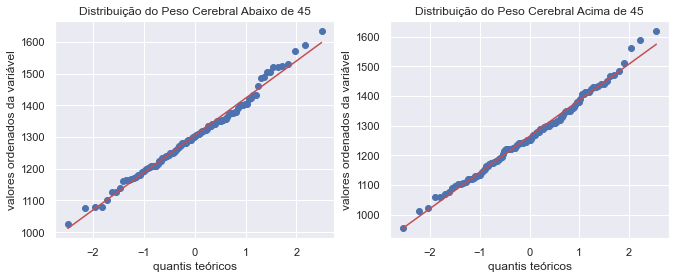

In [68]:
# Vou chamar o método do show_probplot para checar se graficamente os dados se comportam como uma normal
# Utilizo as variáveis da célula acima
ab45 = abaixo45_peso_cerebral
ac45 = acima45_peso_cerebral

msg_1 = 'Distribuição do Peso Cerebral Abaixo de 45'
msg_2 = 'Distribuição do Peso Cerebral Acima de 45'

show_probplot(ab45, ac45, msg_1, msg_2)

<span style='color:black'>A distribuição do peso cerebral entre os grupos abaixo45 e acima45 quase possuem a mesma tendência, com algumas alterações de cada grupo.<br>Vale atentar que no final dos dois grupos os valores começam a sair da reta, apresentando uma semelhença aos dois grupos anteriores, mulheres e homens.<br>
Só pelo gráfico não é suficiente para garantir se assemelha, de fato, a uma distribuição normal ou não. Farei os testes Shapiro-Wilk, D'Agostino e Anderson Darling para identficar se é ou não parecido com uma normal.</span>

In [69]:
# Teste Shapiro-Wilk para identificar se as distribuições são parecidas com a normal ou não.
# Teste do Shapiro somente com os pesos - abaixo45
stats_ab, p_ab = f_shapiro(abaixo45_peso_cerebral)

# Teste do Shapiro somente com os pesos - acima45
stats_ac, p_ac = f_shapiro(acima45_peso_cerebral)

ident = 3 * ' '

print(f'O teste de shapiro-wilk para abaixo45 foi:\n{ident}Valor da estatística do teste = {stats_ab} e o p_valor = {p_ab}')
print(f'\nO teste de shapiro-wilk para acima45 foi:\n{ident}Valor da estatística do teste = {stats_ac} e o p_valor = {p_ac}')

O teste de shapiro-wilk para abaixo45 foi:
   Valor da estatística do teste = 0.9877879619598389 e o p_valor = 0.42216619849205017

O teste de shapiro-wilk para acima45 foi:
   Valor da estatística do teste = 0.9917106032371521 e o p_valor = 0.6554725170135498


In [70]:
# Vou chamar o método que eu criei show_message_is_normal, que chama o método is_normal, 
# para comparar com o meu nível de significância. E avaliar as duas amostras se são, aparentementes, normais
show_message_is_normal(msg_1, msg_2, p_ab, p_ac)

Cenário: Distribuição do Peso Cerebral Abaixo de 45
    O p_valor, 0.4222, é maior em relação ao nível de significância 0.05
    Aceitando a hipótese nula - (Amostra semelhante a uma distribuição normal)

Cenário: Distribuição do Peso Cerebral Acima de 45
    O p_valor, 0.6555, é maior em relação ao nível de significância 0.05
    Aceitando a hipótese nula - (Amostra semelhante a uma distribuição normal)


In [71]:
# Teste D'Agostino para identificar se as distribuições são parecidas com a normal ou não.
# Teste do D'Agostino somente com os pesos abaixo45
stats_abn, p_abn = f_agostino(abaixo45_peso_cerebral)

# Teste do D'Agostino somente com os pesos acima45
stats_acn, p_acn = f_agostino(acima45_peso_cerebral)

ident = 3 * ' '

print(f'O teste de D Agostino para abaixo45 foi:\n{ident}Statistic = {stats_abn} e pvalue = {p_abn}')
print(f'\nO teste de D Agostino para acima45 foi:\n{ident}Statistic = {stats_acn} e pvalue = {p_acn}')

O teste de D Agostino para abaixo45 foi:
   Statistic = 2.397467359200995 e pvalue = 0.3015758618815292

O teste de D Agostino para acima45 foi:
   Statistic = 2.3127154045507394 e pvalue = 0.3146300728188314


In [72]:
show_message_is_normal(msg_1, msg_2, p_abn, p_acn)

Cenário: Distribuição do Peso Cerebral Abaixo de 45
    O p_valor, 0.3016, é maior em relação ao nível de significância 0.05
    Aceitando a hipótese nula - (Amostra semelhante a uma distribuição normal)

Cenário: Distribuição do Peso Cerebral Acima de 45
    O p_valor, 0.3146, é maior em relação ao nível de significância 0.05
    Aceitando a hipótese nula - (Amostra semelhante a uma distribuição normal)


In [73]:
# Teste Anderson-Darling para identificar se as distribuições são parecidas com a normal ou não.
# Teste do Anderson-Darling somente com os pesos abaixo45
p_aba = f_anderson_darling(abaixo45_peso_cerebral)

# Exibir o resultado
show_result_anderson_darling(p_aba)

Possivelmente normal (Gaussiana) com o nível de significância 15.0%
Possivelmente normal (Gaussiana) com o nível de significância 10.0%
Possivelmente normal (Gaussiana) com o nível de significância 5.0%
Possivelmente normal (Gaussiana) com o nível de significância 2.5%
Possivelmente normal (Gaussiana) com o nível de significância 1.0%


In [74]:
# Teste do Anderson-Darling somente com os pesos dos homens
p_aca = f_anderson_darling(acima45_peso_cerebral)

# Exibir o resultado
show_result_anderson_darling(p_aca)

Possivelmente normal (Gaussiana) com o nível de significância 15.0%
Possivelmente normal (Gaussiana) com o nível de significância 10.0%
Possivelmente normal (Gaussiana) com o nível de significância 5.0%
Possivelmente normal (Gaussiana) com o nível de significância 2.5%
Possivelmente normal (Gaussiana) com o nível de significância 1.0%


<span style='color:black'>Após eu passar por 3 métodos diferentes (Shapiro, D'Agostino e Anderson-Darling), concluo que as duas amostras tendem a uma distribuição normal.<br>Nesta análise, eu adotei apenas o nível de significância para rejeitar ou aceitar a hipótese nula, não da questão, mas sim se assemelha uma normal ou não. Vale a atentar que as duas amostras foram avaliadas separadamente.</span>

<span style='color:black'>Realizei o teste do qui-quadrado, porém ele serve para identificar se as amostras são independentes a patir de variáveis categóricas, por exemplo: uma variável qualitativa ordinal - alta, média e baixa.<br>O resultado da estatística do teste foi 0 e do p_valor foi 1, não condizendo, pois houve diferença entre os dois.<br><br>Suponho que as amostras sejam independentes, pois verificaremos os pesos cerebrais de diferentes pessoas e em grupos separados, nesse caso entre abaixo45 e acima45.</span>

<span style='color:black'> Aqui começará uma análise prevendo o comportamento da média, mediana e variância dos grupos acima45 e abaixo45, olhando o teste de hipótese bicaudal. O que eu quero dizer é que eu não vou apenas considerar $\alpha = 5$% com o p_valor, eu também realizarei a comparação da estatística do teste com as regiões críticas. Para consolidar mais as minhas análises e apresentar outra solução para o problema.
</span>

In [75]:
# Teste de Levene para igualdade de variâncias
stats_l, p_l = f_levene(abaixo45_peso_cerebral, acima45_peso_cerebral)

# Método para exibir os testes de igualdade das variâncias
variance = 'variância'
show_result_variance_mean_median(stats_l, p_l, message = variance)

O valor da estatística do teste: 0.1572368955265971
O valor do p_valor: 0.6920731219043006

A estatística de teste, 0.157, não está na região critíca.
Cauda da direta: 0.0250 e Cauda da esquerda: 0.9750
Aceitando a hipótese nula. (A variância das duas amostras são semelhantes)

O p_valor, 0.692, é maior em relação ao nível de siginificância, 0.05
Aceitando a hipótese nula. (A variância das duas amostras são semelhantes)


In [76]:
# Teste de Bartlett para igualdade de variâncias
stats_b, p_b = f_bartlett(abaixo45_peso_cerebral, acima45_peso_cerebral)

# Método para exibir os testes de igualdade das variâncias
# Utilizando da célula acima o parâmetro - variance
show_result_variance_mean_median(stats_b, p_b, message = variance)

O valor da estatística do teste: 0.16822886951883362
O valor do p_valor: 0.6816906880362835

A estatística de teste, 0.168, não está na região critíca.
Cauda da direta: 0.0250 e Cauda da esquerda: 0.9750
Aceitando a hipótese nula. (A variância das duas amostras são semelhantes)

O p_valor, 0.682, é maior em relação ao nível de siginificância, 0.05
Aceitando a hipótese nula. (A variância das duas amostras são semelhantes)


In [77]:
# Teste de Fligner para igualdade de variâncias
stats_f, p_f = f_fligner(abaixo45_peso_cerebral, acima45_peso_cerebral)

# Método para exibir os testes de igualdade ou a diferença das variâncias
# Utilizando da célula acima o parâmetro - variance
show_result_variance_mean_median(stats_f, p_f, message = variance)

O valor da estatística do teste: 0.1443371050223811
O valor do p_valor: 0.7040068536371972

A estatística de teste, 0.144, não está na região critíca.
Cauda da direta: 0.0250 e Cauda da esquerda: 0.9750
Aceitando a hipótese nula. (A variância das duas amostras são semelhantes)

O p_valor, 0.704, é maior em relação ao nível de siginificância, 0.05
Aceitando a hipótese nula. (A variância das duas amostras são semelhantes)


In [78]:
# Teste t de Student comparando médias entre o peso cerebral abaixo45 e o peso cerebral acima45
stats_ts, p_ts = f_t_student(abaixo45_peso_cerebral, acima45_peso_cerebral)

# Método para exibir os testes de igualdade ou a diferença das médias
mean = 'média'
show_result_variance_mean_median(stats_ts, p_ts, message = mean)

O valor da estatística do teste: 2.6355362085897975
O valor do p_valor: 0.008959602315452554

A estatística de teste, 2.6355362085897975, está na região crítica.
A estatística de teste, 2.6355362085897975, se encontra na região da cauda da esquerda, 0.975
Rejeitando a hipótese nula. (A média das duas amostras não são semelhantes)

O p_valor, 0.008959602315452554, é menor em relação ao nível de siginificância, 0.05
Rejeitando a hipótese nula. (A média das duas amostras não são semelhantes)


In [79]:
# Teste Median_test comparando medianas entre o peso cerebral abaixo45 e o peso cerebral acima45
stats_mt, p_mt, median_mt, arr_mt = f_median_t(abaixo45_peso_cerebral, acima45_peso_cerebral)

# Método para exibir os testes de igualdade ou a diferença das medianas
median = 'mediana'
show_result_variance_mean_median(stats_mt, p_mt, message = median)

O valor da estatística do teste: 5.09184191692984
O valor do p_valor: 0.024038646863844833

A estatística de teste, 5.09184191692984, está na região crítica.
A estatística de teste, 5.09184191692984, se encontra na região da cauda da esquerda, 0.975
Rejeitando a hipótese nula. (A mediana das duas amostras não são semelhantes)

O p_valor, 0.024038646863844833, é menor em relação ao nível de siginificância, 0.05
Rejeitando a hipótese nula. (A mediana das duas amostras não são semelhantes)


In [80]:
# Teste Mann Whitney U - Comparação com os dois pesos cerebrais, sendo independentes, para identificar se os dois grupos 
# possuem bastante diferença
stats_mw, p_mw = f_mann_whitney_u(abaixo45_peso_cerebral, acima45_peso_cerebral)

show_result_mwu(stats_mw, p_mw)

O valor da estatística do teste: 8369.5
O valor do p_valor: 0.008550764153552944

A estatística de teste, 8369.5, está na região crítica.
A estatística de teste, 8369.5, se encontra na região da cauda da esquerda, 0.975
Rejeitando a hipótese nula. (Amostras diferentes)

O p_valor, 0.008550764153552944, é menor em relação ao nível de siginificância, 0.05
Rejeitando a hipótese nula. (Amostras diferentes)


<span style='color:black'>Uma vez que foi identificado que as duas amostras se assemelham a uma distribuição normal e durante as inferências estatísticas a média e a mediana dos grupos foram constatadas que são diferentes.<br>O próximo passo será eu exibir as duas amostras com o comportamento de distribuição normal.</span>

<span style='color:black'>Em relação ao outliers, aparentemente, não foram influentes, pois as médias e as medianas estão próximas, respectivamente ao seu grupo.<br>Concluí, embora tenha outliers, eles não são influentes a ponto de alterarem de forma brusca as médias das amostras.</span>

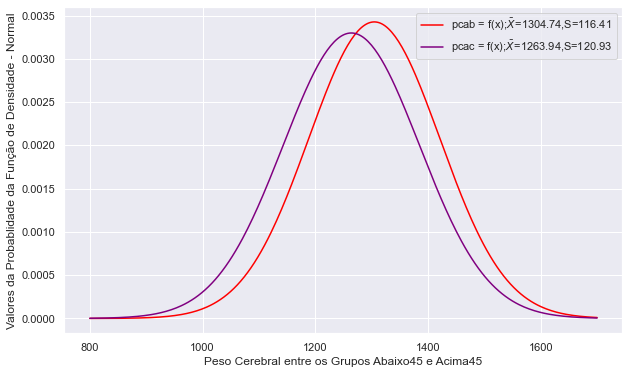

O intervalo de confiança para pcab são: 1282.7380 e 1326.7347 - A média é = 1304.7364
O intervalo de confiança para pcac são: 1242.7018 e 1285.1722 - A média é = 1263.9370


In [81]:
# Grupos de abaixo45 e acima45
media_ab = abaixo45_peso_cerebral.mean()
media_ac = acima45_peso_cerebral.mean()

# Usando o desvio padrão amostral - Considerando com graus de liberdade igual a 1
dp_ab_a = abaixo45_peso_cerebral.std() # mesmo efeito do np.std(ddof = 1)
dp_ac_a = acima45_peso_cerebral.std() # mesmo efeito do np.std(ddof = 1)

# Usando o desvio padrão populacional - Considerando com graus de liberdade igual a 0
dp_ab_p = abaixo45_peso_cerebral.std(ddof = 0) # mesmo efeito do np.std() - ddof = 0
dp_ac_p = acima45_peso_cerebral.std(ddof = 0) # mesmo efeito do np.std() - ddof = 0

# Desvio padrão populacional do conjunto - Considerando com graus de liberdade igual a 0
dpp = df_brain[col_pes].std(ddof = 0) # mesmo efeito do np.std() - ddof = 0

# Chamando o método do desvio padrão divido pela raiz quadrada do tamanho da amostra
c_dp_ab = f_c_dpp_amst(dp_ab_a, abaixo45_peso_cerebral)
c_dp_ac = f_c_dpp_amst(dp_ac_a, acima45_peso_cerebral)

# Erro padrão da média
epm_ab = sem(abaixo45_peso_cerebral)
epm_ac = sem(acima45_peso_cerebral)

# Recuperando o tamanho de cada amostra
tam_n_ab = len(abaixo45_peso_cerebral)
tam_n_ac = len(acima45_peso_cerebral)

# Chamando método para criar um array com os valores abaixo45 e acima45
# Aproveitei para utilizar o dataframe com a coluna do Peso, definida nas primeiras células do desenvolvimento dessa questão
arr_ab_ac = f_def_array(df_brain[col_pes].values)

# Número para ajudar no "layout" da distribuição x - Distribuição de Abaixo45 e Acima45
nmin = 155
nmax = 65

# Será enviado como parâmetro para o método do plot_normal_distribution
lst_num = [nmin, nmax]

# Definições de mensagens
msg_a = 'pcab' # peso_cerebral_abaixo45
msg_b = 'pcac' # peso_cerebral_acima45
text  = 'Peso Cerebral entre os Grupos Abaixo45 e Acima45'

# Definição do alpha
alpha = 0.05

ic = 1 - alpha # Intervalo de confiança

ic_ab = f_def_t_ic(ic, tam_n_ab - 1, media_ab, epm_ab) # Definindo o intervalo de do peso cerebral abaixo45
ic_ac = f_def_t_ic(ic, tam_n_ac - 1, media_ac, epm_ac) # Definindo o intervalo de confiança do peso cerebral acima45

# Chamando o método para fazer os gráficos dos pesos entre os grupos abaixo45 e acima45
plot_normal_distribution(arr_ab_ac, media_ab, dp_ab_a, media_ac, dp_ac_a, msg_a, msg_b, lst_num, ic_ab, ic_ac, text)

# Exibir o gráfico
plt.show()

# Exibir o resultado dos intervalos de confiança mais as médias das duas amostras
show_confidence_int_mean(msg_a, msg_b, ic_ab, ic_ac, media_ab, media_ac)

<span style='color:black'>Os dois grupos, abaixo45 e acima45, as suas distribuições estão bem mais próximas em relação aos grupos, mulheres e homens.<br>A distribuição do abaixo45 está um pouco mais a direita, enquanto a distribuição do acima45 um pouco a mais para a esquerda. São bem parecidas, com a distribuição vermelha um pouco mais alta.<br>Em comparação com o cenário das outras duas ditribuições, seus valores de densidade normal estão um pouco mais baixo.<br>Por fim, embora sejam uma próxima da outra existe uma certa diferença, o que leva a conclusão, após uma série de testes mais a representação da distribuição normal, para os grupos etários também temos diferenças.</span>

### Exercicio 2

O tamanho da cabeça é preditor do peso cerebral e, neste caso, há diferença nessa relação entre os sexos e entre os grupos etários?

<span style='color: blue'>Antes de fato responder a essas três questões da alternativa 2, dividi a pergunta em três etapas. Eu farei uma busca por melhores modelos para, posteriormente, responder as questões.</span>

#### Hipóteses
$H_0:\beta 1 = 0$   (Não há relação entre X = Tamanho e y = Peso)

$H_a:\beta 1 \neq 0$  (Há alguma relação entre X = Tamanho e y = Peso)

$H_0:\beta 2 = 0$   (Não há relação entre X = Homem e y = Peso)

$H_a:\beta 2 \neq 0$  (Há alguma relação entre X = Homem e y = Peso)

$H_0:\beta 3 = 0$   (Não há relação entre X = Acima45 e y = Peso)

$H_a:\beta 3 \neq 0$  (Há alguma relação entre X = Acima45 e y = Peso)

$\alpha $ = 0,05  (Nível de significância)</span>

In [82]:
# Realizar a centralização e transnformação da variável explicativa quantitativa - Tamanho
Tamanho_c   = df_brain.Tamanho - df_brain.Tamanho.mean() # Cálcula centralizando a variável
l2_tamanho  = np.log2(df_brain.Tamanho)                  # Cálcula a partir do log com a base 2
l10_tamanho = np.log10(df_brain.Tamanho)                 # Cálcula a partir do log com a base 10
le_tamanho  = np.log(df_brain.Tamanho)                   # Cálcula a partir do log com o número de euler

# Realizar a centralização e transnformação da variável resposta - Peso
Peso_c   = df_brain.Peso - df_brain.Peso.mean()          # Cálcula centralizando a variável
l2_peso  = np.log2(df_brain.Peso)                        # Cálcula a partir do log com a base 2
l10_peso = np.log10(df_brain.Peso)                    # Cálcula a partir do log com a base 10
le_peso  = np.log(df_brain.Peso)                      # Cálcula a partir do log com o número de euler

# Realizar a padronização da variável explicativa quantitativa - Tamanho
Tamanho_p = zscore(df_brain.Tamanho)

# Realizar a padronização da variável resposta - Peso
Peso_p = zscore(df_brain.Peso)

In [83]:
lst_atr_brain = ['Tamanho', 'Homem', 'Acima45', 'Peso']

X = df_brain[lst_atr_brain[0:3]] # Minhas features
y = df_brain[lst_atr_brain[-1]] # Variável Resposta

model_fr = forward_regression(X, y, 0.05)
print(f'Variáveis selecionadas via forward: {model_fr}')

model_br = backward_regression(X, y, 0.05)
print(f'Variáveis selecionadas via backward: {model_br}')

C:\Users\Arion\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  # Remove the CWD from sys.path while we load stuff.


Variáveis selecionadas via forward: ['Tamanho', 'Acima45', 'Homem']
Variáveis selecionadas via backward: ['Tamanho', 'Homem', 'Acima45']


<span style='color:black'>Eu fiz uma primeira análise executando a seleção das variáveis preditoras a partir das técnicas: forward e backward. Ambas técnicas trouxeram as variáveis: Tamanho, Acima45 e Homem.</span>

In [84]:
form = 'Peso ~ Homem * Acima45 * Tamanho'

res_ols = execute_ols(form, df_brain)

                            OLS Regression Results                            
Dep. Variable:                   Peso   R-squared:                       0.661
Model:                            OLS   Adj. R-squared:                  0.650
Method:                 Least Squares   F-statistic:                     63.68
Date:                Sun, 21 Jun 2020   Prob (F-statistic):           2.90e-50
Time:                        16:35:05   Log-Likelihood:                -1343.0
No. Observations:                 237   AIC:                             2702.
Df Residuals:                     229   BIC:                             2730.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept               399.89

<span style='color: black'>Próxima etapa: <ul><li>Retirar a interação do Homem com o Tamanho e o Acima45</li></ul>Motivo:<ul><li>O p_valor é altíssimo,comparando com o $\alpha$ = 5%, e, para o teste de hipótese, estou aceitando que o $\beta1$ é igual a 0. Portanto, diz que a interação entre esses atributos não existe relação.</li></ul></span>

In [85]:
form = 'Peso ~ Tamanho * Homem + Tamanho * Acima45'

res_ols = execute_ols(form, df_brain)

                            OLS Regression Results                            
Dep. Variable:                   Peso   R-squared:                       0.656
Model:                            OLS   Adj. R-squared:                  0.649
Method:                 Least Squares   F-statistic:                     88.22
Date:                Sun, 21 Jun 2020   Prob (F-statistic):           1.36e-51
Time:                        16:35:06   Log-Likelihood:                -1344.5
No. Observations:                 237   AIC:                             2701.
Df Residuals:                     231   BIC:                             2722.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept         381.4911    101.303     

<span style='color: black'>Próxima etapa: <ul><li>Retirar a interação do Tamanho com Acima45</li></ul>Motivo:<ul><li>O p_valor alto, comparando com o $\alpha$ = 5%, e, para o teste de hipótese, estou aceitando que o $\beta1$ é igual a 0. Portanto, diz que a interação entre esses atributos não existe relação.</li></ul></span>

In [86]:
form = 'Peso ~ Tamanho * Homem + Acima45'

res_ols = execute_ols(form, df_brain)

                            OLS Regression Results                            
Dep. Variable:                   Peso   R-squared:                       0.655
Model:                            OLS   Adj. R-squared:                  0.649
Method:                 Least Squares   F-statistic:                     110.0
Date:                Sun, 21 Jun 2020   Prob (F-statistic):           2.05e-52
Time:                        16:35:08   Log-Likelihood:                -1345.1
No. Observations:                 237   AIC:                             2700.
Df Residuals:                     232   BIC:                             2717.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept       322.5451     83.436      3.866

<span style='color: black'>Próxima etapa: <ul><li>Retirar a interação do Tamanho com Homem.</li></ul>Motivo:<ul><li>O p_valor alto, comparando com o $\alpha$ = 5%, e, para o teste de hipótese, estou aceitando que o $\beta1$ é igual a 0. Portanto, diz que a interação entre esses atributos não existe relação.</li></ul></span>

In [87]:
form = 'Peso ~ Tamanho + Homem + Acima45'

res_ols = execute_ols(form, df_brain)

                            OLS Regression Results                            
Dep. Variable:                   Peso   R-squared:                       0.653
Model:                            OLS   Adj. R-squared:                  0.648
Method:                 Least Squares   F-statistic:                     146.0
Date:                Sun, 21 Jun 2020   Prob (F-statistic):           2.94e-53
Time:                        16:35:09   Log-Likelihood:                -1345.7
No. Observations:                 237   AIC:                             2699.
Df Residuals:                     233   BIC:                             2713.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    395.5079     52.999      7.463      0.0

<span style='color: black'>Próxima etapa: <ul><li>Trabalhar com esse modelo, no qual, diz que as variáveis Homem, Acima45 e Tamanho possuem influência no intercepto.</li></ul>Motivo:<ul><li>Os p_valores baixos (Mesmo o do Homem que é um p_valor significativo), comparando com o $\alpha$ = 5%, e, para o teste de hipótese, rejeito que o $\beta1$, $\beta2$ e $\beta3$ são iguais a 0. Portanto, diz que a interação de cada atributo com o predito existe relação.</li></ul></span>
<span style='color: black'>Eu cheguei no mesmo resultado, aplicando o método BidirectionalStepwiseSelection. Executei o método para dar confiabilidade ao resultado gerado no passo anterior, fazendo o "backward" manual.</span>

In [88]:
model = BidirectionalStepwiseSelection(X, y, model_type ="linear", elimination_criteria = "r2", 
                                       varchar_process = "dummy", senter=0.05, sstay=0.05)

Character Variables (Dummies Generated): []
break : No need to Backward Elimination
Entered : Tamanho 	R2 : 0.639311719957
break : No need to Backward Elimination
Entered : Acima45 	R2 : 0.646642093196705
break : No need to Backward Elimination
Entered : Homem 	R2 : 0.6528346387526655
Break : Significance Level
                            OLS Regression Results                            
Dep. Variable:                   Peso   R-squared:                       0.653
Model:                            OLS   Adj. R-squared:                  0.648
Method:                 Least Squares   F-statistic:                     146.0
Date:                Sun, 21 Jun 2020   Prob (F-statistic):           2.94e-53
Time:                        16:35:11   Log-Likelihood:                -1345.7
No. Observations:                 237   AIC:                             2699.
Df Residuals:                     233   BIC:                             2713.
Df Model:                           3                  

<span style='color:black'>Validarei se esse método gerado é realmente o melhor o modelo, mas para isso aplicarei a análise de resíduos.</span>

In [89]:
# Chamando o método para executar o ypred, dffis, diagonal da matriz hat...
ypred, residuo, infl, hii, res_stud, res_stud_del, dffits, p_d, cook, p_c  = execute_res_ols(res_ols)

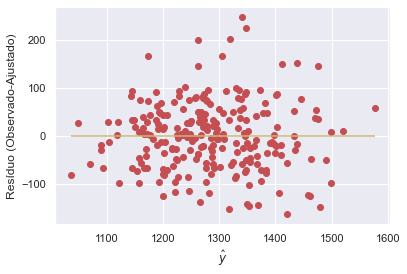

In [90]:
plot_residuals_obs_adj(ypred, residuo)

plt.show()

<span style='color:black'>Pelo o gráfico de resíduos observado - ajustado, percebo que embora estejam aleatóriamente em torno de 0 - linha amarela, alguns pontos estão acima de 200.<br>Para isso aplicarei os resíduos padronizados.</span>

Raiz MSE: 70.76


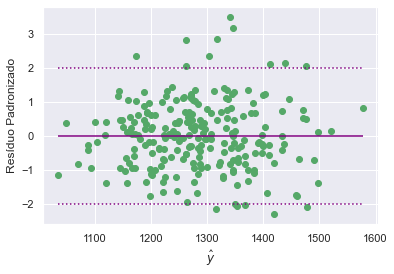

In [91]:
rmse_peso = rmse(df_brain.Peso, ypred)

print(f'Raiz MSE: {rmse_peso:.2f}')

plot_standardized_residuals_rmse(ypred, residuo, rmse_peso)

plt.show()

<span style='color:black'>Com o resíduo padronizado, percebo que o modelo não consegue explicar todos os dados inseridos.<br>Explorarei mais a situação dos resíduos.</span>

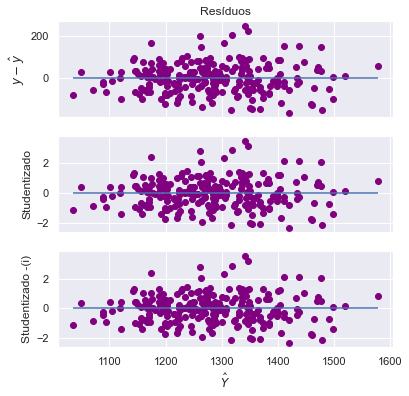

In [92]:
plot_all_residuals(ypred, residuo, res_stud, res_stud_del)

plt.show()

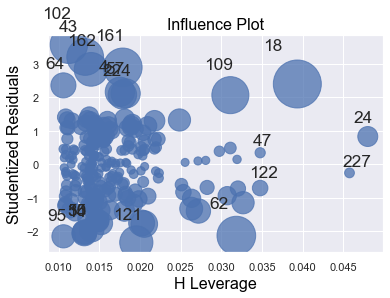

In [93]:
plot_check_residuals(res_ols)

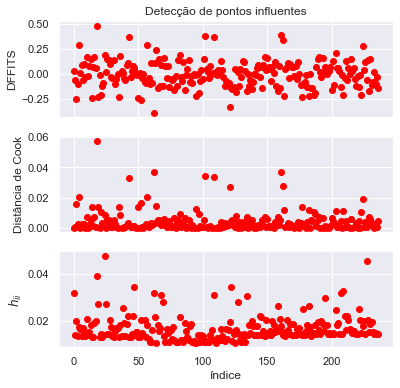

In [94]:
detect_inf_points(df_brain, dffits, cook, hii);

<span style='color:black'>A maior parte dos dados estão em torno de 0. Porém, alguns deles fogem do escopo das demais.<br>Ainda sim, são poucos pontos que o modelo não consegue explicar, olhando para as demais análises: resíduos padronizados, diagonal da matriz hat, distância de cook e o plot de influência.<br>Em relação ao plot de influência, uma boa parte dos dados se encontram próximo a 0, porém tenho algumas observações, aparentemente, problemáticas: 18, 102, 43 e 62, por exemplo. Precisarei padronizar ou transformar para tentar evitar as influências dessas variáveis problemáticas.</span>

In [95]:
# Análise pelo Gênero - VIF
form = 'Peso ~ Tamanho + Homem + Acima45'

res_vif = execute_vif(form, df_brain)

res_vif

VIF Factor   Features
0  130.725965  Intercept
1    1.402975    Tamanho
2    1.398371      Homem
3    1.040419    Acima45

<span style='color:black'>Executei o VIF e o modelo possui a multicolinearidade no intercepto. Farei outros testes para encontrar o modelo ideal.</span>

#### Aplicando o modelo com centralização (a média - a média do conjunto)

<span style='color:black'>Aplicarei o modelo normalizado e farei alguns testes parecidos com o modelo sem normalização para encontrar o melhor modelo e explorá-lo na parte de análise de resíduos.</span>

In [96]:
form = 'Peso ~ Tamanho_c * Homem + Tamanho_c * Acima45'

res_ols = execute_ols(form, df_brain)

                            OLS Regression Results                            
Dep. Variable:                   Peso   R-squared:                       0.656
Model:                            OLS   Adj. R-squared:                  0.649
Method:                 Least Squares   F-statistic:                     88.22
Date:                Sun, 21 Jun 2020   Prob (F-statistic):           1.36e-51
Time:                        16:35:23   Log-Likelihood:                -1344.5
No. Observations:                 237   AIC:                             2701.
Df Residuals:                     231   BIC:                             2722.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept          1287.5274      9.55

In [97]:
form = 'Peso ~ Tamanho_c + Homem + Acima45'

res_ols_c = execute_ols(form, df_brain)

                            OLS Regression Results                            
Dep. Variable:                   Peso   R-squared:                       0.653
Model:                            OLS   Adj. R-squared:                  0.648
Method:                 Least Squares   F-statistic:                     146.0
Date:                Sun, 21 Jun 2020   Prob (F-statistic):           2.94e-53
Time:                        16:35:24   Log-Likelihood:                -1345.7
No. Observations:                 237   AIC:                             2699.
Df Residuals:                     233   BIC:                             2713.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   1282.9713      8.703    147.412      0.0

<span style='color:black'>Não visualizei mudança, fazendo a centralização da variável preditora tamanho.<br>Analisarei a parte de resíduos para avaliar esse modelo com mais precisão.</span>

In [98]:
# Chamando o método para executar o ypred, dffis, diagonal da matriz hat...
ypred_c, residuo_c, infl_c, hii_c, res_stud_c, res_stud_del_c, dffits_c, p_d_c, cook_c, p_c_c  = execute_res_ols(res_ols)

Raiz MSE: 70.40


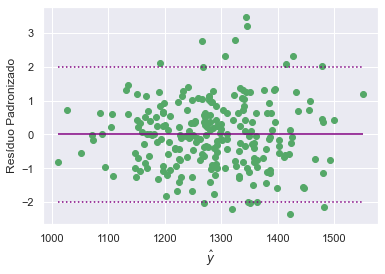

In [99]:
rmse_peso_c = rmse(df_brain.Peso, ypred_c)

print(f'Raiz MSE: {rmse_peso_c:.2f}')

plot_standardized_residuals_rmse(ypred_c, residuo_c, rmse_peso_c)

plt.show()

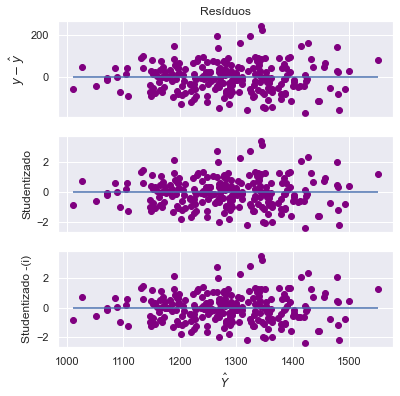

In [100]:
plot_all_residuals(ypred_c, residuo_c, res_stud_c, res_stud_del_c)

plt.show()

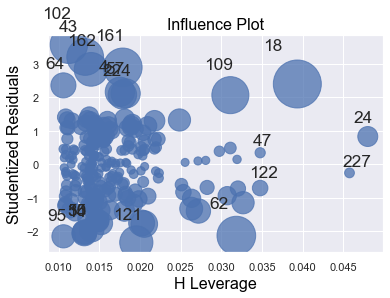

In [101]:
plot_check_residuals(res_ols_c)

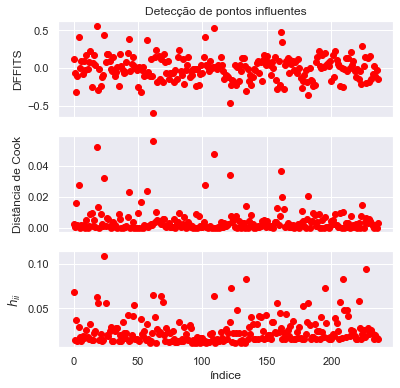

In [102]:
detect_inf_points(df_brain, dffits_c, cook_c, hii_c);

<span style='color:black'>Embora foi aplicado a centralização da variável quantitativa - tamanho - usando o cálculo da média do registros menos a média do conjunto, não foi suficiente para que o modelo explicasse todos os resíduos. Inclusive a distância de cook está com mais dados distantes de 0, comparando com os dados sem a normalização.</span>

In [103]:
# Análise pelo Gênero - VIF
form = 'Peso ~ Tamanho_c + Homem + Acima45'

res_vif = execute_vif(form, df_brain)

res_vif

VIF Factor   Features
0    3.525323  Intercept
1    1.402975  Tamanho_c
2    1.398371      Homem
3    1.040419    Acima45

<span style='color:black'>O VIF foi baixo, porém a análise de resíduos, matriz diagonal de hat e a distância de cook, mostrou que o modelo não consegue explicar mais variáveis em relação ao modelo anterior.</span>

<span style='color: black'>Centralizando a variável resposta e averiguando as possibilidades com e sem interações da variáveis explicativas.</span>

In [104]:
form = 'Peso_c ~ Tamanho_c * Homem + Tamanho_c * Acima45'

res_ols = execute_ols(form, df_brain)

                            OLS Regression Results                            
Dep. Variable:                 Peso_c   R-squared:                       0.656
Model:                            OLS   Adj. R-squared:                  0.649
Method:                 Least Squares   F-statistic:                     88.22
Date:                Sun, 21 Jun 2020   Prob (F-statistic):           1.36e-51
Time:                        16:35:34   Log-Likelihood:                -1344.5
No. Observations:                 237   AIC:                             2701.
Df Residuals:                     231   BIC:                             2722.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept             4.6540      9.55

In [105]:
form = 'Peso_c ~ Tamanho_c + Homem + Acima45'

res_ols_c = execute_ols(form, df_brain)

                            OLS Regression Results                            
Dep. Variable:                 Peso_c   R-squared:                       0.653
Model:                            OLS   Adj. R-squared:                  0.648
Method:                 Least Squares   F-statistic:                     146.0
Date:                Sun, 21 Jun 2020   Prob (F-statistic):           2.94e-53
Time:                        16:35:35   Log-Likelihood:                -1345.7
No. Observations:                 237   AIC:                             2699.
Df Residuals:                     233   BIC:                             2713.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0979      8.703      0.011      0.9

<span style='color:black'>Com as interações com a variável quantitativa, tamanho, centralizada e após a tentativa de centralizar a resposta também, sem e com as possíveis interações. Descarto a possibilidade de centralizar a variável resposta e a variável explicativa quantitativa, subtraíndo a média pela média do conjunto. Farei outros testes, aplicando transformadas utilizando log para verificar se há alguma melhora.</span>

#### Aplicando Log2 (Testes com ou sem interação entre as variáveis explicativas)

In [106]:
form = 'Peso ~ l2_tamanho * Homem + l2_tamanho * Acima45'

res_ols = execute_ols(form, df_brain)

                            OLS Regression Results                            
Dep. Variable:                   Peso   R-squared:                       0.656
Model:                            OLS   Adj. R-squared:                  0.648
Method:                 Least Squares   F-statistic:                     88.04
Date:                Sun, 21 Jun 2020   Prob (F-statistic):           1.59e-51
Time:                        16:35:37   Log-Likelihood:                -1344.7
No. Observations:                 237   AIC:                             2701.
Df Residuals:                     231   BIC:                             2722.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept          -5746.7808    824

In [107]:
form = 'Peso ~ l2_tamanho + Homem + Acima45'

res_ols = execute_ols(form, df_brain)

                            OLS Regression Results                            
Dep. Variable:                   Peso   R-squared:                       0.655
Model:                            OLS   Adj. R-squared:                  0.650
Method:                 Least Squares   F-statistic:                     147.2
Date:                Sun, 21 Jun 2020   Prob (F-statistic):           1.65e-53
Time:                        16:35:37   Log-Likelihood:                -1345.1
No. Observations:                 237   AIC:                             2698.
Df Residuals:                     233   BIC:                             2712.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept  -6030.3493    446.676    -13.500      0.0

In [108]:
form = 'l2_peso ~ l2_tamanho + Homem + Acima45'

res_ols = execute_ols(form, df_brain)

                            OLS Regression Results                            
Dep. Variable:                l2_peso   R-squared:                       0.664
Model:                            OLS   Adj. R-squared:                  0.659
Method:                 Least Squares   F-statistic:                     153.2
Date:                Sun, 21 Jun 2020   Prob (F-statistic):           7.39e-55
Time:                        16:35:39   Log-Likelihood:                 267.58
No. Observations:                 237   AIC:                            -527.2
Df Residuals:                     233   BIC:                            -513.3
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      2.0762      0.495      4.193      0.0

<span style='color:black'>Não consegui retirar o warning de multicolinearidade, porém com a variável resposta também normalizada obtive que o meu $\beta{2}$ foi aceito que ele é diferente de 0. Ou seja, rejeito a minha hipótese nula e o atributo Homem possui interação com a variável resposta.<br>Explorarei mais a parte da análise de resíduos para esse modelo.</span>

In [109]:
# Chamando o método para executar o ypred, dffis, diagonal da matriz hat...
ypred_l2, residuo_l2, infl_l2, hii_l2, res_st_l2, res_st_dl_l2, dffits_l2, p_d_l2, cook_l2, p_c_l2  = execute_res_ols(res_ols)

Raiz MSE: 1278.20


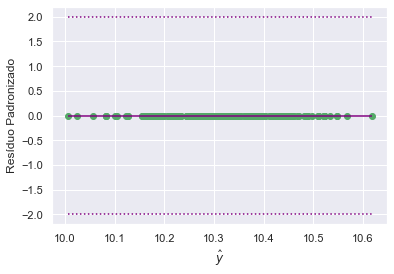

In [110]:
rmse_peso_l2 = rmse(df_brain.Peso, ypred_l2)

print(f'Raiz MSE: {rmse_peso_l2:.2f}')

plot_standardized_residuals_rmse(ypred_l2, residuo_l2, rmse_peso_l2)

plt.show()

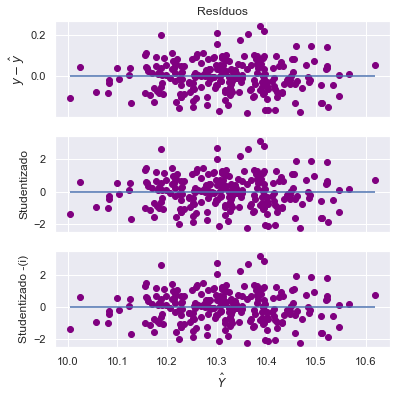

In [111]:
plot_all_residuals(ypred_l2, residuo_l2, res_st_l2, res_st_dl_l2)

plt.show()

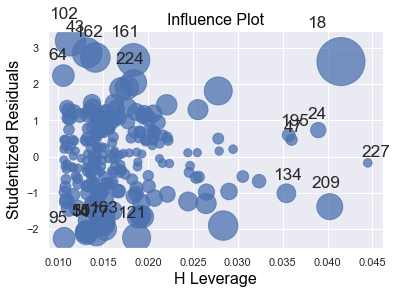

In [112]:
plot_check_residuals(res_ols)

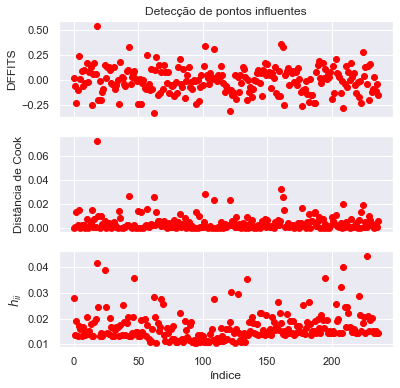

In [113]:
detect_inf_points(df_brain, dffits_l2, cook_l2, hii_l2);

<span style='color:black'>Modelo se comportando muito bem até que na representação dos resíduos ajustado - padronizado, todos os dados estão zerados, isso é forte indício de overffitting.<br>O comportamento dos dados em torno do 0 também refletiu nas demais representações de resíduos. Embora a questão de overffiting elimine o modelo, farei o teste do VIF.</span>

In [114]:
# Análise pelo Gênero - VIF
form = 'l2_peso ~ l2_tamanho + Homem + Acima45'

res_vif = execute_vif(form, df_brain)

res_vif

VIF Factor    Features
0  9332.045366   Intercept
1     1.412668  l2_tamanho
2     1.407695       Homem
3     1.041295     Acima45

<span style='color:black'>Mais um motivo para descartar esse modelo: Fator de inflação de variância altíssima no intercepto, peso.</span>

#### Aplicando Log e - Neperiano (Testes com ou sem interação entre as variáveis explicativas)

In [115]:
form = 'Peso ~ le_tamanho * Homem + le_tamanho * Acima45'

res_ols = execute_ols(form, df_brain)

                            OLS Regression Results                            
Dep. Variable:                   Peso   R-squared:                       0.656
Model:                            OLS   Adj. R-squared:                  0.648
Method:                 Least Squares   F-statistic:                     88.04
Date:                Sun, 21 Jun 2020   Prob (F-statistic):           1.59e-51
Time:                        16:35:49   Log-Likelihood:                -1344.7
No. Observations:                 237   AIC:                             2701.
Df Residuals:                     231   BIC:                             2722.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept          -5746.7808    824

In [116]:
form = 'Peso ~ le_tamanho + Homem + Acima45'

res_ols = execute_ols(form, df_brain)

                            OLS Regression Results                            
Dep. Variable:                   Peso   R-squared:                       0.655
Model:                            OLS   Adj. R-squared:                  0.650
Method:                 Least Squares   F-statistic:                     147.2
Date:                Sun, 21 Jun 2020   Prob (F-statistic):           1.65e-53
Time:                        16:35:50   Log-Likelihood:                -1345.1
No. Observations:                 237   AIC:                             2698.
Df Residuals:                     233   BIC:                             2712.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept  -6030.3493    446.676    -13.500      0.0

In [117]:
form = 'le_peso ~ le_tamanho + Homem + Acima45'

res_ols = execute_ols(form, df_brain)

                            OLS Regression Results                            
Dep. Variable:                le_peso   R-squared:                       0.664
Model:                            OLS   Adj. R-squared:                  0.659
Method:                 Least Squares   F-statistic:                     153.2
Date:                Sun, 21 Jun 2020   Prob (F-statistic):           7.39e-55
Time:                        16:35:51   Log-Likelihood:                 354.44
No. Observations:                 237   AIC:                            -700.9
Df Residuals:                     233   BIC:                            -687.0
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      1.4391      0.343      4.193      0.0

<span style='color:black'>Sem a interação e com a variável resposta também normalizada, eu consegui resolver a questão da multicolinearidade e do $\beta{2}$.<br>Mesmo encontrando um forte candidato, continuarei testando os possiveis ajustes no modelo</span>

In [118]:
# Chamando o método para executar o ypred, dffis, diagonal da matriz hat...
ypred_le, residuo_le, infl_le, hii_le, res_st_le, res_st_dl_le, dffits_le, p_d_le, cook_le, p_c_le  = execute_res_ols(res_ols)

Raiz MSE: 1281.35


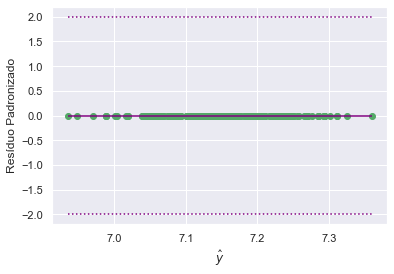

In [119]:
rmse_peso_le = rmse(df_brain.Peso, ypred_le)

print(f'Raiz MSE: {rmse_peso_le:.2f}')

plot_standardized_residuals_rmse(ypred_le, residuo_le, rmse_peso_le)

plt.show()

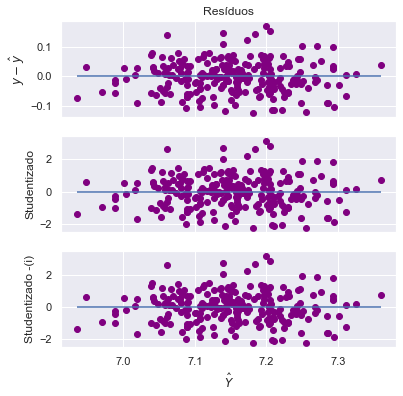

In [120]:
plot_all_residuals(ypred_le, residuo_le, res_st_le, res_st_dl_le)

plt.show()

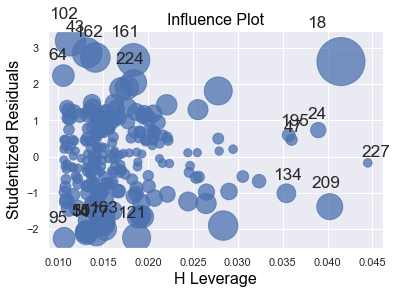

In [121]:
plot_check_residuals(res_ols)

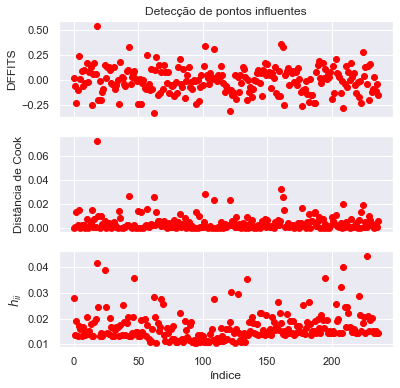

In [122]:
detect_inf_points(df_brain, dffits_le, cook_le, hii_le);

<span style='color:black'>Modelo se comportando muito bem até que na representação dos resíduos ajustado - padronizado, todos os dados estão zerados, isso é forte indício de overffitting.<br>O comportamento dos dados em torno do 0 também refletiu nas demais representações de resíduos. Embora a questão de overffiting elimine o modelo, farei o teste do VIF.</span>

In [123]:
# Análise pelo Gênero - VIF
form = 'le_peso ~ le_tamanho + Homem + Acima45'

res_vif = execute_vif(form, df_brain)

res_vif

VIF Factor    Features
0  9332.045366   Intercept
1     1.412668  le_tamanho
2     1.407695       Homem
3     1.041295     Acima45

<span style='color:black'>Mais um motivo para descartar esse modelo: Fator de inflação de variância altíssima no intercepto, peso.</span>

#### Aplicando Log10 (Testes com ou sem interação entre as variáveis explicativas)

In [124]:
form = 'Peso ~ l10_tamanho * Homem + l10_tamanho * Acima45'

res_ols = execute_ols(form, df_brain)

                            OLS Regression Results                            
Dep. Variable:                   Peso   R-squared:                       0.656
Model:                            OLS   Adj. R-squared:                  0.648
Method:                 Least Squares   F-statistic:                     88.04
Date:                Sun, 21 Jun 2020   Prob (F-statistic):           1.59e-51
Time:                        16:36:00   Log-Likelihood:                -1344.7
No. Observations:                 237   AIC:                             2701.
Df Residuals:                     231   BIC:                             2722.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept           -5746.7808    

In [125]:
form = 'Peso ~ l10_tamanho + Homem + Acima45'

res_ols = execute_ols(form, df_brain)

                            OLS Regression Results                            
Dep. Variable:                   Peso   R-squared:                       0.655
Model:                            OLS   Adj. R-squared:                  0.650
Method:                 Least Squares   F-statistic:                     147.2
Date:                Sun, 21 Jun 2020   Prob (F-statistic):           1.65e-53
Time:                        16:36:05   Log-Likelihood:                -1345.1
No. Observations:                 237   AIC:                             2698.
Df Residuals:                     233   BIC:                             2712.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept   -6030.3493    446.676    -13.500      

In [126]:
form = 'l10_peso ~ l10_tamanho + Homem + Acima45'

res_ols = execute_ols(form, df_brain)

                            OLS Regression Results                            
Dep. Variable:               l10_peso   R-squared:                       0.664
Model:                            OLS   Adj. R-squared:                  0.659
Method:                 Least Squares   F-statistic:                     153.2
Date:                Sun, 21 Jun 2020   Prob (F-statistic):           7.39e-55
Time:                        16:36:06   Log-Likelihood:                 552.11
No. Observations:                 237   AIC:                            -1096.
Df Residuals:                     233   BIC:                            -1082.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept       0.6250      0.149      4.193      

<span style='color:black'>Resultado semelhante ao obtido com a normalização aplicado o Log de base e - Neperiano.</span>

In [127]:
# Chamando o método para executar o ypred, dffis, diagonal da matriz hat...
ypred_l, residuo_l, infl_l, hii_l, res_st_l, res_st_dl_l, dffits_l, p_d_l, cook_l, p_c_l  = execute_res_ols(res_ols)

Raiz MSE: 1285.39


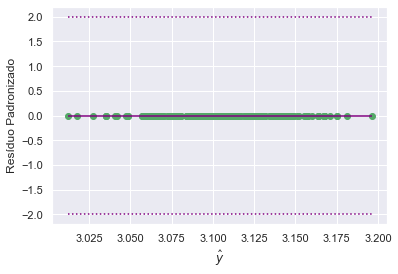

In [128]:
rmse_peso_l = rmse(df_brain.Peso, ypred_l)

print(f'Raiz MSE: {rmse_peso_l:.2f}')

plot_standardized_residuals_rmse(ypred_l, residuo_l, rmse_peso_l)

plt.show()

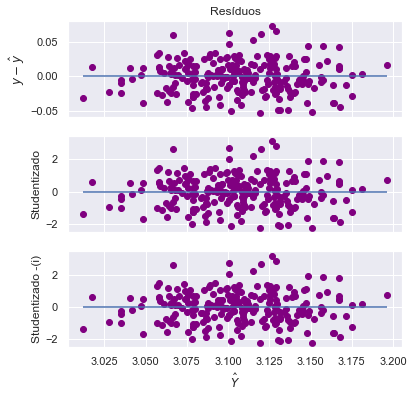

In [129]:
plot_all_residuals(ypred_l, residuo_l, res_st_l, res_st_dl_l)

plt.show()

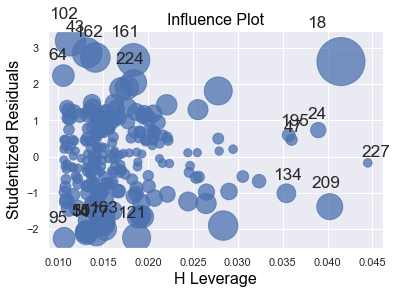

In [130]:
plot_check_residuals(res_ols)

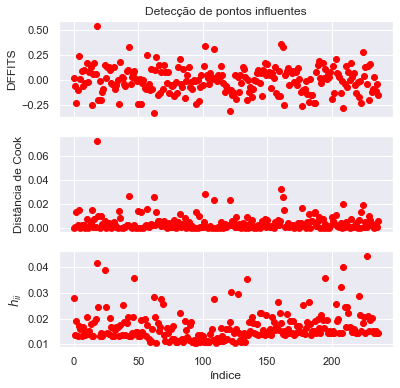

In [131]:
detect_inf_points(df_brain, dffits_l, cook_l, hii_l);

<span style='color:black'>Modelo se comportando muito bem até que na representação dos resíduos ajustado - padronizado, todos os dados estão zerados, isso é forte indício de overffitting.<br>O comportamento dos dados em torno do 0 também refletiu nas demais representações de resíduos. Embora a questão de overffiting elimine o modelo, farei o teste do VIF.</span>

In [132]:
# Análise pelo Gênero - VIF
form = 'l10_peso ~ l10_tamanho + Homem + Acima45'

res_vif = execute_vif(form, df_brain)

res_vif

VIF Factor     Features
0  9332.045366    Intercept
1     1.412668  l10_tamanho
2     1.407695        Homem
3     1.041295      Acima45

<span style='color:black'>Mais um motivo para descartar esse modelo: Fator de inflação de variância altíssima no intercepto, peso.</span>

<span style='color:black'>A questão da multicolinearidade foi resolvida com log de euler e o log na base 10 e não tenho p_valor igual ou acima para compararmos com o $\alpha = 5$%.<br>Para o intervalo de confiança as três abordagens foram semelhantes, tendo uma diferença no log da base neperiano e da base 2, onde a variável explicativa Homem não tem o intervalo começando a partir de 0, diferentemente da abordagem com log da base 10.<br>Porém, olhando e analisando os resíduos, na representação do resíduo padronizado se comportou de maneira muito estranha, entendo que possa ter ocorrido overfitting.<br>A representação de resíduos studentizados houve uma maior distribuição dos dados, mas compreendo que não tenha resolvido a questão dos dados influentes, visto que o ponto 18 se distânciou mais nas 3 normalizações.</span>

##### <span style='color:black'>Por último, atacarei a padronização por z-score</span>

In [133]:
# Análise com o tamanho padronizado - zscore
# Análise pelo Gênero - Executar OLS
form = 'Peso ~ Tamanho_p * Homem + Tamanho_p * Acima45'

res_ols = execute_ols(form, df_brain)

                            OLS Regression Results                            
Dep. Variable:                   Peso   R-squared:                       0.656
Model:                            OLS   Adj. R-squared:                  0.649
Method:                 Least Squares   F-statistic:                     88.22
Date:                Sun, 21 Jun 2020   Prob (F-statistic):           1.36e-51
Time:                        16:36:19   Log-Likelihood:                -1344.5
No. Observations:                 237   AIC:                             2701.
Df Residuals:                     231   BIC:                             2722.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept          1287.5274      9.55

In [134]:
# Análise com o tamanho padronizado - zscore
# Análise pelo Gênero - Executar OLS
form = 'Peso ~ Tamanho_p + Homem + Acima45'

res_ols = execute_ols(form, df_brain)

                            OLS Regression Results                            
Dep. Variable:                   Peso   R-squared:                       0.653
Model:                            OLS   Adj. R-squared:                  0.648
Method:                 Least Squares   F-statistic:                     146.0
Date:                Sun, 21 Jun 2020   Prob (F-statistic):           2.94e-53
Time:                        16:36:22   Log-Likelihood:                -1345.7
No. Observations:                 237   AIC:                             2699.
Df Residuals:                     233   BIC:                             2713.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   1282.9713      8.703    147.412      0.0

<span style='color:black'>Modelo até aqui teve um bom resultado: p_valores abaixo do $\alpha = 5$% e, aparentemente, sem a questão da multicolinearidade.</span>

In [135]:
# Chamando o método para executar o ypred, dffis, diagonal da matriz hat...
ypred_p, residuo_p, infl_p, hii_p, res_st_p, res_st_dl_p, dffits_p, p_d_p, cook_p, p_c_p  = execute_res_ols(res_ols)

Raiz MSE: 70.76


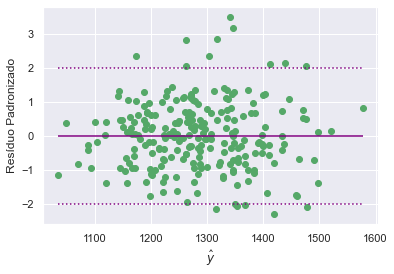

In [136]:
rmse_peso_p = rmse(df_brain.Peso, ypred_p)

print(f'Raiz MSE: {rmse_peso_p:.2f}')

plot_standardized_residuals_rmse(ypred_p, residuo_p, rmse_peso_p)

plt.show()

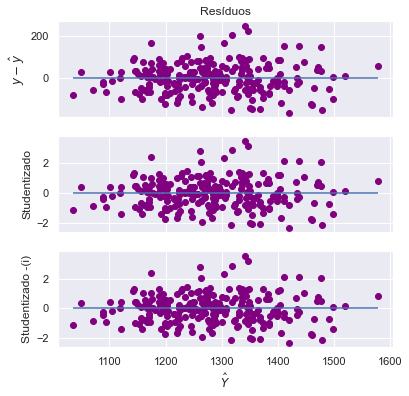

In [137]:
plot_all_residuals(ypred_p, residuo_p, res_st_p, res_st_dl_p)

plt.show()

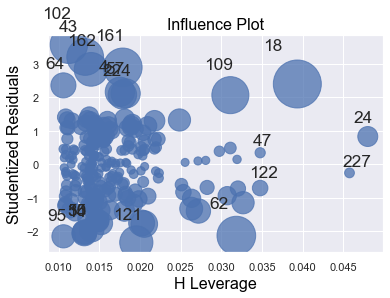

In [138]:
plot_check_residuals(res_ols)

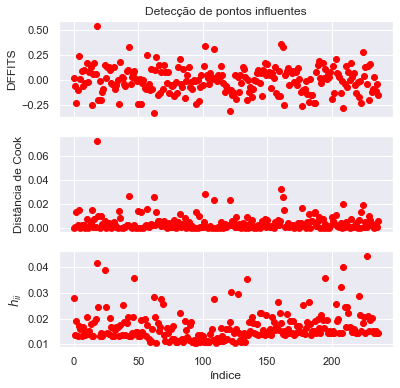

In [139]:
detect_inf_points(df_brain, dffits_l, cook_l, hii_l);

<span style='color:black'>Modelo com alguns resíduos altos, porém no geral, em comparação com modelos anteriores, foi até agora o melhor.<br>Próxima etapa é executar o VIF.</span>

In [140]:
# Análise pelo Gênero - VIF
form = 'Peso ~ Tamanho_p + Homem + Acima45'

res_vif = execute_vif(form, df_brain)

res_vif

VIF Factor   Features
0    3.525323  Intercept
1    1.402975  Tamanho_p
2    1.398371      Homem
3    1.040419    Acima45

<span stye='color:black'>Mais um motivo para utilizar esse modelo, pois a questão de multicolinearidade não existe e dentro da análise de resíduos teve um resultado satisfatório em comparação com os demais.</span>

#### Teste com a variável resposta e explicativa padronizada - Zscore

In [141]:
# Análise com o tamanho padronizado - zscore
# Análise pelo Gênero - Executar OLS
form = 'Peso_p ~ Tamanho_p * Homem + Tamanho_p * Acima45'

res_ols = execute_ols(form, df_brain)

                            OLS Regression Results                            
Dep. Variable:                 Peso_p   R-squared:                       0.656
Model:                            OLS   Adj. R-squared:                  0.649
Method:                 Least Squares   F-statistic:                     88.22
Date:                Sun, 21 Jun 2020   Prob (F-statistic):           1.36e-51
Time:                        16:36:33   Log-Likelihood:                -209.73
No. Observations:                 237   AIC:                             431.5
Df Residuals:                     231   BIC:                             452.3
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept             0.0388      0.08

In [142]:
# Análise com o tamanho padronizado - zscore
# Análise pelo Gênero - Executar OLS
form = 'Peso_p ~ Tamanho_p + Homem + Acima45'

res_ols = execute_ols(form, df_brain)

                            OLS Regression Results                            
Dep. Variable:                 Peso_p   R-squared:                       0.653
Model:                            OLS   Adj. R-squared:                  0.648
Method:                 Least Squares   F-statistic:                     146.0
Date:                Sun, 21 Jun 2020   Prob (F-statistic):           2.94e-53
Time:                        16:36:33   Log-Likelihood:                -210.92
No. Observations:                 237   AIC:                             429.8
Df Residuals:                     233   BIC:                             443.7
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0008      0.072      0.011      0.9

<span style='color:black'>Não continuarei a análise para esse último modelo, pois o intercepto está com um valor altíssimo e mantenho, dentre os modelos que eu testei, o penúltimo modelo - SEM INTERAÇÃO E COM A PADRONIZAÇÃO DO Z-SCORE NA VARIÁVEL TAMANHO - como o melhor das possibilidades de testes que realizei.</span>

#### <span style='color:black'>Melhor modelo dos quais eu testei: Sem interação e com a padronização do z-score na variável Tamanho</span>
<span style='color:black'>Responderei as três etapas da questão 2 de acordo com esse modelo</span>

<span style='color:black'> O tamanho da cabeça é preditor do peso cerebral<br><ul><li>y = Peso</li><li>X = Tamanho</li></ul></span>

#### Hipóteses
$H_0:\beta 1 = 0$   (Não há relação entre Tamanho = X e Peso = y)

$H_a:\beta 1 \neq 0$  (Há alguma relação entre Tamanho = X e Peso = y)

$\alpha $ = 0,05  (Nível de significância)</span>

In [143]:
col_pes = 'Peso'
col_tam = 'Tamanho'
col_hom = 'Homem'
col_aci = 'Acima45'
col_gen = 'Genero'
col_age = 'Idade'

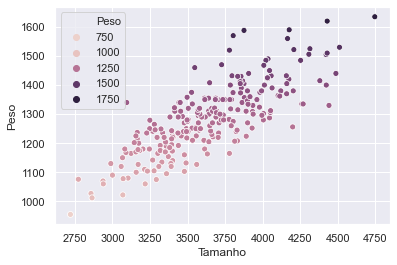

In [144]:
# Neste ponto, eu puxei o peso x tamanho por terem uma certa correlação.
# Por esse gráfico, eu percebo que quanto maior o peso, geralmente, o tamanho é maior também.
sns.scatterplot(df_brain[col_tam], df_brain[col_pes], hue=df_brain[col_pes]);

<span style='color:black'>Na representação dos dados com os valores do Peso e Tamanho, os dois atributos possuem uma certa relação, tanto que quanto maior o tamanho, geralmente, o peso também fica maior.<br>Farei um teste, a partir de pearson, para identificar o resultado da correlação entre os dois atributos.</span>

In [145]:
# Criando uma lista de variáveis para avaliar sua correlação
lst_corr = [col_pes, col_tam]

# Usando a correlação do pandas - selecionando o parâmetro de pearson para identificar as variáveis mais correlacionadas
corr     = df_brain[lst_corr].corr(method = 'pearson')

# Utilizando o comprenhension para maximizar a performance com os for aninhados
var = [round(np.abs(corr[i][j]), 2) for i in corr.columns for j in corr.columns if i != j]

print(f'Correlação entre os atributos {lst_corr[0]} e {lst_corr[1]}: {var[0]}')

Correlação entre os atributos Peso e Tamanho: 0.8


<span style='color:black'>Correlação alta entre as duas variáveis, 80%, indicando que o tamanho tem influência na variável resposta, peso.</span>

In [146]:
# Análise pelo df_brain
form = 'Peso ~ Tamanho_p'

res_ols = execute_ols(form, df_brain)

                            OLS Regression Results                            
Dep. Variable:                   Peso   R-squared:                       0.639
Model:                            OLS   Adj. R-squared:                  0.638
Method:                 Least Squares   F-statistic:                     416.5
Date:                Sun, 21 Jun 2020   Prob (F-statistic):           5.96e-54
Time:                        16:36:45   Log-Likelihood:                -1350.3
No. Observations:                 237   AIC:                             2705.
Df Residuals:                     235   BIC:                             2711.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   1282.8734      4.705    272.683      0.0

<span style='color:black'>Considerações: <ul><li>O p_valor está com o resultado zerado para as duas variáveis (resposta e preditora), portanto eu rejeito minha hipótese nula $\beta1$ = 0.</li><li>Os coeficientes do intercepto - Resposta: Peso - e da preditora Tamanho são diferentes de 0.</li></ul>Isso significa que ocorre uma relação entre os dois atributos e o Tamanho influência no peso, para um ${R^2}$ de $\approx$ 64%.</span>

In [147]:
# Análise pelo Gênero - VIF
form = 'Peso ~ Tamanho_p'

res_vif = execute_vif(form, df_brain)

res_vif

VIF Factor   Features
0         1.0  Intercept
1         1.0  Tamanho_p

<span style='color:black'>Executando o fator de inflação da variação para esse cenário, o intercepto e a variável preditora com VIF baixo.</span>

<span style='color:black'><strong>e, neste caso, há diferença nessa relação entre os sexos e entre os grupos etários?</strong></span>

<span style='color:black'>Análise para identificar se há diferença na relação entre os sexos.</span>

In [148]:
# Análise pelo Gênero - Executar OLS
form = 'Peso ~ Tamanho_p * Homem'

res_ols = execute_ols(form, df_brain)

                            OLS Regression Results                            
Dep. Variable:                   Peso   R-squared:                       0.645
Model:                            OLS   Adj. R-squared:                  0.641
Method:                 Least Squares   F-statistic:                     141.3
Date:                Sun, 21 Jun 2020   Prob (F-statistic):           3.53e-52
Time:                        16:36:49   Log-Likelihood:                -1348.3
No. Observations:                 237   AIC:                             2705.
Df Residuals:                     233   BIC:                             2718.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept        1277.4461      8.791    1

In [149]:
# Análise pelo Gênero - VIF
form = 'Peso ~ Tamanho_p * Homem'

res_vif = execute_vif(form, df_brain)

res_vif

VIF Factor         Features
0    3.520214        Intercept
1    3.546596        Tamanho_p
2    1.409580            Homem
3    2.896413  Tamanho_p:Homem

In [150]:
# Análise pelo Gênero - Executar OLS
form = 'Peso ~ Tamanho_p + Homem'

res_ols = execute_ols(form, df_brain)

                            OLS Regression Results                            
Dep. Variable:                   Peso   R-squared:                       0.643
Model:                            OLS   Adj. R-squared:                  0.640
Method:                 Least Squares   F-statistic:                     211.0
Date:                Sun, 21 Jun 2020   Prob (F-statistic):           4.15e-53
Time:                        16:36:50   Log-Likelihood:                -1348.9
No. Observations:                 237   AIC:                             2704.
Df Residuals:                     234   BIC:                             2714.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   1272.7745      7.801    163.163      0.0

In [151]:
# Análise pelo Gênero - VIF
form = 'Peso ~ Tamanho_p + Homem'

res_vif = execute_vif(form, df_brain)

res_vif

VIF Factor   Features
0    2.768218  Intercept
1    1.359153  Tamanho_p
2    1.359153      Homem

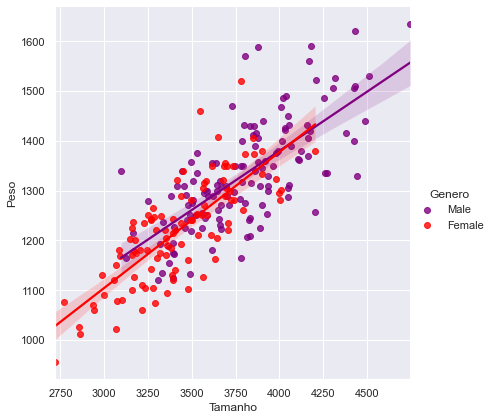

In [152]:
lst_color = ['purple', 'red']

res = f_get_plot_dff_gropus(col_tam, col_pes, col_gen, df_brain, lst_color)

<span stye='color:black'>Fiz a representação dos dados Peso x Tamanho da representação linear dos sexos, para mostrar que há diferença entre os grupos, principalmente no ínicio e no final deles, no meio as duas retas se encontram.<br>As inclinações das retas estão diferentes e iniciam e finalizam em etapas diferentes, siginficando que existe uma diferença considerável entre os pesos e tamanhos cerebrais de cada grupo.</span>

<span style='color:black'>Análise para identificar se há diferença na relação entre os grupos etários.</span>

In [153]:
# Análise pelo Gênero - Executar OLS
form = 'Peso ~ Tamanho_p * Acima45'

res_ols = execute_ols(form, df_brain)

                            OLS Regression Results                            
Dep. Variable:                   Peso   R-squared:                       0.648
Model:                            OLS   Adj. R-squared:                  0.644
Method:                 Least Squares   F-statistic:                     143.2
Date:                Sun, 21 Jun 2020   Prob (F-statistic):           1.28e-52
Time:                        16:36:58   Log-Likelihood:                -1347.2
No. Observations:                 237   AIC:                             2702.
Df Residuals:                     233   BIC:                             2716.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept          1294.5983      6.89

In [154]:
# Análise pelo Gênero - VIF
form = 'Peso ~ Tamanho_p * Acima45'

res_vif = execute_vif(form, df_brain)

res_vif

VIF Factor           Features
0    2.182456          Intercept
1    2.174911          Tamanho_p
2    1.011467            Acima45
3    2.160470  Tamanho_p:Acima45

In [155]:
# Análise pelo Gênero - Executar OLS
form = 'Peso ~ Tamanho_p + Acima45'

res_ols = execute_ols(form, df_brain)

                            OLS Regression Results                            
Dep. Variable:                   Peso   R-squared:                       0.647
Model:                            OLS   Adj. R-squared:                  0.644
Method:                 Least Squares   F-statistic:                     214.1
Date:                Sun, 21 Jun 2020   Prob (F-statistic):           1.38e-53
Time:                        16:37:01   Log-Likelihood:                -1347.8
No. Observations:                 237   AIC:                             2702.
Df Residuals:                     234   BIC:                             2712.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   1293.9828      6.870    188.345      0.0

In [156]:
# Análise pelo Gênero - VIF
form = 'Peso ~ Tamanho_p + Acima45'

res_vif = execute_vif(form, df_brain)

res_vif

VIF Factor   Features
0    2.167523  Intercept
1    1.011240  Tamanho_p
2    1.011240    Acima45

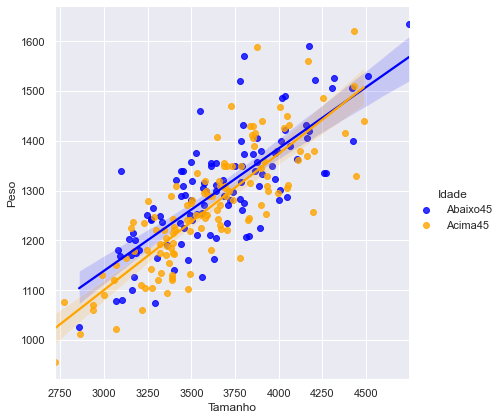

In [157]:
lst_color = ['blue', 'orange']

res = f_get_plot_dff_gropus(col_tam, col_pes, col_age, df_brain, lst_color)

<span stye='color:black'>Fiz a representação dos dados Tamanho x Peso dos grupos abaixo45 e acima45, para mostrar que há diferença entre os grupos, principalmente no final deles, no meio as duas retas se encontram. No caso do grupos abaixo45 e acima45 as duas retas iniciam e finalizam quase iguais. Além disso, as duas retas são próximas e com inclinações um pouco próximas, significando que as duas amostras são um pouco mais parecidas em relação aos grupos Mulheres e Homens.<br>Mesmo parecidas isso não significa que sejam semelhantes, pois percebe-se que existe uma diferença perceptível das suas inclinações, iniciam e finalizam em momento diferentes.</span>

<span style='color:black'>Análise com todos os cenários</span>

In [158]:
# Análise pelo Gênero - Executar OLS
form = 'Peso ~ Tamanho_p + Genero + Idade'

res_ols = execute_ols(form, df_brain)

                            OLS Regression Results                            
Dep. Variable:                   Peso   R-squared:                       0.653
Model:                            OLS   Adj. R-squared:                  0.648
Method:                 Least Squares   F-statistic:                     146.0
Date:                Sun, 21 Jun 2020   Prob (F-statistic):           2.94e-53
Time:                        16:39:15   Log-Likelihood:                -1345.7
No. Observations:                 237   AIC:                             2699.
Df Residuals:                     233   BIC:                             2713.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept         1282.9713      8.703  

<span style='color:black'>Embora o modelo com interações entre as variáveis homens e tamanho ficou com o p_valor bem alto e isso significa que não há interação entre essas duas variáveis preditoras com a peso, ainda sim a variável homem possui relação com o intercepto. Demonstrando no melhor modelo o seu p_valor é baixo. Além disso, os gráficos lmplot mostram as diferenças dos grupos, interagindo a variável resposta e com a variável explicativa quantitativa tamanho.<br><br>No caso dos grupos abaixo45 e acima45, sem interação já foi melhor, ou seja, rejeitando a hipótese nula de que não existe relação entre as variáveis explicativas com a variável resposta.</span>

<span style='color: blue'>Nesse último modelo, percebam que eu coloquei as duas variáveis que eu inserir categóricas para atribuir siginifcados para 0 e 1. Não ocorreu mudança no modelo porque com 0 e 1 ele separava a minha categoria referência 0 e fazia a análise sobre a 1, fato que se confirma quando eu utilizo os dois atributos com texto. E fiz isso para facilitar a minha análise final.</span>

<span style='color:black'>Interpretando-o: <ol><li>Intercepto: 1282,9713 é o valor esperado do peso para tamanho_p, homem e acima45.</li><li>A menor distância entre os intervalos do tamanho é de 20,635 enquanto o intervalo de confiança do grupo de Homens é de $\approx$ 44. Isso significa que quanto maior a distância, mas eu estou perdendo a precisão do meu intervalo.</li><li>Para o atributo Homem o valor do coeficiente, 22,54, é a diferença no Peso para o grupo de Homens, pois ele considera o valor 0, Mulheres, sendo a minha categoria referência.</li><li>Ao atributo Acima45 o valor do coeficiente é negativo, -23,96, eu entendi que seja negativo porque a minha categoria referência é 0, grupo abaixo45. A média de Abaixo45 é maior que a média do Acima45, o qual é interpretado no modelo.Se eu recuperar a primeira questão do exercício, percebe-se que a distrubuição do Abaixo45 ela é um pouco mais a direita.</li></ol></span>

### Exercício 3

Estime o peso médio do cérebro de homens e de mulheres (pontual e intervalar).

In [159]:
# Nesta célula definirei os dados que eu utilizarei para as próximas células, embora declaradas na primeira questão - a
# Repeti aqui para facilitar para quem estiver analisando.
media_m  = mulheres_peso_cerebral.mean()
media_h  = homens_peso_cerebral.mean()

# Desvio padrão amostral - Considerando com graus de liberdade igual a 1
dp_m_a = mulheres_peso_cerebral.std() # mesmo efeito do np.std(ddof = 1)
dp_h_a = homens_peso_cerebral.std() # mesmo efeito do np.std(ddof = 1)

# Desvio padrão populacional - Considerando com graus de liberdade igual a 0
dp_m_p = mulheres_peso_cerebral.std(ddof = 0) # mesmo efeito do np.std() - ddof = 0
dp_h_p = homens_peso_cerebral.std(ddof = 0) # mesmo efeito do np.std() - ddof = 0

# Desvio padrão populacional do conjunto - Considerando com graus de liberdade igual a 0
dpp   = df_brain[col_pes].std(ddof = 0) # mesmo efeito do np.std() - ddof = 0

# Variância amostral - Considerando com graus de liberdade igual a 1
variance_m_a = mulheres_peso_cerebral.var() # mesmo efeito do np.var(ddof = 1)
variance_h_a = homens_peso_cerebral.var() # mesmo efeito do np.var(ddof = 1)

# Variância populacional - Considerando com graus de liberdade igual a 0
variance_m_p = mulheres_peso_cerebral.var(ddof = 0) # mesmo efeito do np.var() - ddof = 0
variance_h_p = homens_peso_cerebral.var(ddof = 0) # mesmo efeito do np.var() - ddof = 0

# Tamanho da amostra
tam_n_m = len(mulheres_peso_cerebral)
tam_n_h = len(homens_peso_cerebral)

In [160]:
# Chamando método para criar um array com os valores das mulheres e dos homens
# Aproveitei para utilizar o dataframe com a coluna do Peso, definida nas primeiras células do desenvolvimento dessa questão
arr_m_h  = f_def_array(df_brain[col_pes].values)

# Número para ajudar no "layout" da distribuição x - Distribuição de Abaixo45 e Acima45
nmin = 180
nmax = 200

# Será enviado como parâmetro para o método do plot_normal_distribution
lst_num = [nmin, nmax]

# Definições de mensagens
msg_a = 'pcm'
msg_b = 'pch'
text  = 'Peso Cerebral entre os Grupos Mulheres e Homens'

In [161]:
# Nesta célula definirei alguns cálculos que eu farei para a estimar os intervalos de confianças, usando a normal ou t student
# Erro padrão da média
epm_m = sem(mulheres_peso_cerebral)
epm_h = sem(homens_peso_cerebral)

# Chamando o método do desvio padrão populacional divido pela raiz quadrada do tamanho da amostra
c_dp_m = f_c_dpp_amst(dpp, mulheres_peso_cerebral)
c_dp_h = f_c_dpp_amst(dpp, homens_peso_cerebral)

# Definição do alpha
alpha = 0.05

# Intervalo de confiança
ic = 1 - alpha 

# Chamando o método de cálculo do intervalo de confiança pela normal
ic_m = f_def_n_ic(ic, media_m, c_dp_m) # Intervalo de confiança do peso cerebral das mulheres
ic_h = f_def_n_ic(ic, media_h, c_dp_h) # Intervalo de confiança do peso cerebral dos homens

# Chamando o método de cálculo da região crítica por t Student(n - 1)
ic_t_m = f_def_t_ic(ic, tam_n_m - 1, media_m, epm_m) # Intervalo de confiança do peso cerebral das mulheres
ic_t_h = f_def_t_ic(ic, tam_n_h - 1, media_h, epm_h) # Intervalo de confiança do peso cerebral dos homens

# Chamando o método de cálculo do intervalo de confiança por t Student(n - 1). 
# De outro jeito - Usando DescrStatsW().tconfint_mean()
ic_dws_m = f_def_dws_ic(mulheres_peso_cerebral)
ic_dws_h = f_def_dws_ic(homens_peso_cerebral) 

#### Pontual

<span style='color:black'>Farei a estimação pontual a partir do método de máxima verossimilhança (MV)</span>

<span style='color:blue'>Eu sei que, para a estimação pontual, o estimador de máxima verossimilhança é a média de cada uma das amostras (Apresentarei o cálculo para provar a minha afirmação e explicar o código que eu utilizarei).<br>Eu vou inserir a resposta de forma mais sucinta, no entanto quero aplicar a abordagem de outro jeito: aplicarei a função da verossimilhança, usando log likelihood, e identificar qual é a melhor média para cada amostra, separarei as amostras ao invés de utilizar o conjunto todo igual ao exemplo da Média das escolas na aula 4.</span>

<span>Cálculo da função da verossimilhança:<br><br>$$L(p) = \prod_{i = 1}^{n} p^{x_{i}} (1 - p)^{1 - x_{i}} = p^{\sum^{n}}_{i = 1} (1 - p)^{n - \sum^{n}_{i = 1} x_{i}}$$<br><br>Mas somente o cálculo da função da verossimilhança não é suficiente, para isso precisarei maximizar, usarei o log natural na função.<br><br>$$l(p) = lnL(p) = \sum^{n}_{i = 1} x_{i}ln(p) + (n - \sum^{n}_{i = 1} x{i}) ln(1 - p)$$<br><br>Derivando p:<br><br>$$\frac{dl(p)}{dp} = \frac{(1 - p) \sum^{n}_{i = 1}x{i}}{p} - \frac{(n - \sum^{n}_{i = 1} x{i})}{1 - p} = 0 \Rightarrow \hat{p} = \frac{\sum^{n}_{i = 1} x_{i}}{n} = \bar{x}$$<br><br>Este último cálculo é a somatória das amostras de um conjunto, por exemplo: a somatória do peso cerebral dos dados do grupo de mulheres, dividido pelo tamanho do conjunto igual a minha média amostral para o nosso estimador $\hat{p}$.<br><br>Para a demonstração em python, utilizarei também o seguinte cálculo para a amostra de distribuição normal:<br><br>$$L(\mu, \sigma^{2}) = \prod^{n}_{i = 1} \frac{1}{\sqrt{2 \pi \sigma{2}}} e^{- \frac{(x_{i} - \mu)^{2}}{2 \sigma^{2}}}$$<br><br>Aplicarei utilizando o log da verossimilhança a partir da distribuição normal.</span>

In [162]:
print(f'O valor pontual da máxima verossimilhança do peso cerebral entre as mulheres é de : {media_m:.4f}')
print(f'O valor pontual da máxima verossimilhança do peso cerebral entre os homens é de : {media_h:.4f}')

O valor pontual da máxima verossimilhança do peso cerebral entre as mulheres é de : 1219.1456
O valor pontual da máxima verossimilhança do peso cerebral entre os homens é de : 1331.8582


<span style='color:black'>Abaixo aplicarei o cálculo da função da verossimilhança com o log de likelihood.</span>

In [163]:
x_m = np.linspace(min(mulheres_peso_cerebral), max(mulheres_peso_cerebral), 1000)
x_h = np.linspace(min(homens_peso_cerebral), max(homens_peso_cerebral), 1000)

# Para a amostra de valores mulheres, homens e para o desvio padrão suposto conhecido e igual ao amostral, 
# calcula a verossimilhança para diversos valores de média
L1 = L_amostra(mulheres_peso_cerebral, x_m, dp_m_a) # Mulheres
L2 = L_amostra(homens_peso_cerebral, x_h, dp_h_a) # Homens

Calculando a melhor média para a amostra do peso cerebral das mulheres:
   Desvio padrão amostral: 103.8299
   Melhor mu: 1219.1191


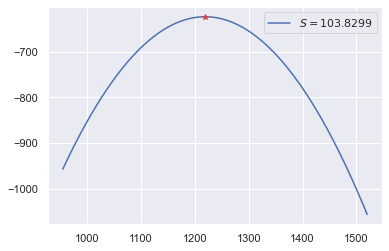

In [164]:
print(f'Calculando a melhor média para a amostra do peso cerebral das mulheres:')

ident = 3 * ' '

print(f'{ident}Desvio padrão amostral: {dp_m_a:.4f}')

theta = x_m # parâmetro para variar as médias amostrais
f_theta1 = np.array([f_get_ll_normal(mulheres_peso_cerebral, mu, dp_m_a) for mu in theta])

show_plot_mv(theta, f_theta1, dp_m_a, ident)

Calculando a melhor média para a amostra do peso cerebral dos homens:
   Desvio padrão amostral: 108.9334
   Melhor mu: 1331.8769


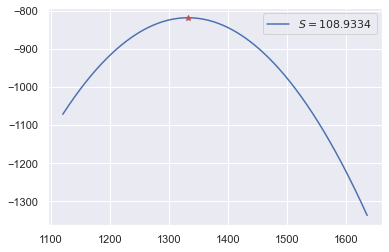

In [165]:
print(f'Calculando a melhor média para a amostra do peso cerebral dos homens:')

ident = 3 * ' '

print(f'{ident}Desvio padrão amostral: {dp_h_a:.4f}')

theta = x_h # parâmetro para variar as médias amostrais
f_theta1 = np.array([f_get_ll_normal(homens_peso_cerebral, mu, dp_h_a) for mu in theta])

show_plot_mv(theta, f_theta1, dp_h_a, ident)

<span style='color: black'>Teve uma pequena diferença e isso ocorreu porque eu utilizo um parâmetro no linspace que influência a formação dos intervalos do conjunto de dados para cada uma das amostras.<br>Essa influência foi o principal motivo para eu não utilizar o conjunto todo, pois eu precisaria ajustar o passo a passo dessa formação dos intervalos das médias dentro do conjunto e chegar numa resposta que fosse parecido com a média disponibilizada no começo desse exercício para cada um dos grupos, o teste seria mais na tentativa e erro.<br>Este tipo de teste não seria uma boa análise, portanto separei as duas amostras pegando o valor mínimo e máximo de cada uma e fiz o passo a passo com a formação dos intervalos, apliquei o mesmo número para formação do intervalo para as duas amostras.<br><br>O meu principal objetivo foi demonstrar pelo cálculo da função da verossimilhança e chegar a um resultado parecido, com o da média, ou próximo para ambas as amostras. Finalizo essa parte da estimação pontual.</span>

#### Intervalar

<span style='color:black'>Farei a estimação intervalar a partir do intervalo da confiança da média (com variância desconhecida).<br>Eu acabei fazendo a estimação intervalar e mostrei "plotando" a distribuição normal na primeira questão - a.</span>

##### Intervalo de confiança para média (variância desconhecida) - T Student

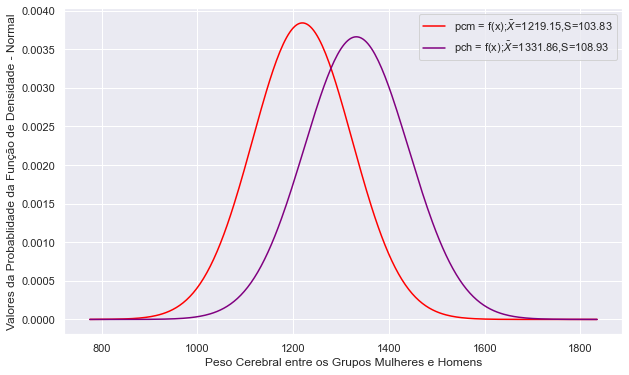

O intervalo de confiança para pcm são: 1198.8532 e 1239.4381 - A média é = 1219.1456
O intervalo de confiança para pch são: 1313.2448 e 1350.4716 - A média é = 1331.8582


In [166]:
# Chamando o método para fazer os gráficos dos pesos entre os grupos mulheres e homens
plot_normal_distribution(arr_m_h, media_m, dp_m_a, media_h, dp_h_a, msg_a, msg_b, lst_num, ic_t_m, ic_t_h, text)

# Exibir o gráfico - antes da mensagem
plt.show()

# Exibir o resultado dos intervalos de confiança mais as médias das duas amostras
show_confidence_int_mean(msg_a, msg_b, ic_t_m, ic_t_h, media_m, media_h)

##### Intervalo de confiança para média (variância desconhecida) - Outro jeito utilizando o DescrStatsW().tconfint_mean()

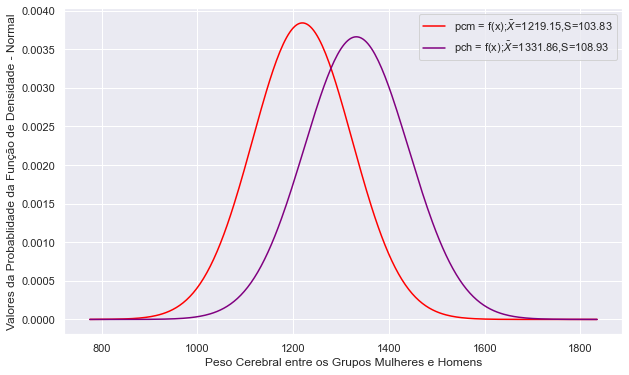

O intervalo de confiança para pcm são: 1198.8532 e 1239.4381 - A média é = 1219.1456
O intervalo de confiança para pch são: 1313.2448 e 1350.4716 - A média é = 1331.8582


In [167]:
# Chamando o método para fazer os gráficos dos pesos entre os grupos mulheres e homens
plot_normal_distribution(arr_m_h, media_m, dp_m_a, media_h, dp_h_a, msg_a, msg_b, lst_num, ic_dws_m, ic_dws_h, text)

# Exibir o gráfico - antes da mensagem
plt.show()

# Exibir o resultado dos intervalos de confiança mais as médias das duas amostras
show_confidence_int_mean(msg_a, msg_b, ic_dws_m, ic_dws_h, media_m, media_h)

<span style='color:black'>Sem a variância populacional conhecida, executei dos dois jeitos para consolidar mais o conhecimento adquirido.<br>Percebe-se que a média de cada uma das amostras se encontra no intervalo de confiança gerados.</span>

##### Intervalo de confiança para média (variância conhecida)

<span style='color:black'>Nesta parte, explorarei o desvio padrão populacional de todo o meu conjunto e dividir pela quantidade de dados de cada amostra, isto é, aplicarei o desvio padrão do conjunto / nº de elementos respectivamente de cada amostra. A partir disso aplicarei a média de cada amostra para avaliar quais foram os meus intervalos de confiança e se isso, de certa forma, é semelhante com as respostas das duas células, com as representações, acimas.</span>

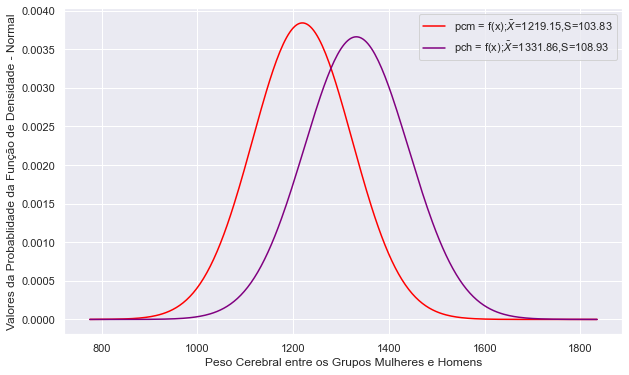

O intervalo de confiança para pcm são: 1195.9544 e 1242.3368 - A média é = 1219.1456
O intervalo de confiança para pch são: 1311.5258 e 1352.1906 - A média é = 1331.8582


In [168]:
# Chamando o método para fazer os gráficos dos pesos entre os grupos mulheres e homens
plot_normal_distribution(arr_m_h, media_m, dp_m_a, media_h, dp_h_a, msg_a, msg_b, lst_num, ic_m, ic_h, text)

# Exibir o gráfico - antes da mensagem
plt.show()

# Exibir o resultado dos intervalos de confiança mais as médias das duas amostras
show_confidence_int_mean(msg_a, msg_b, ic_m, ic_h, media_m, media_h)

<span style='color: black'>Neste teste eu tentei supor que a minha população fosse o conjunto todo e a partir daí calcular o desvio padrão divido pela quantidade de cada uma.<br>Embora os intervalos de confiança sejam próximos aos dois testes com a variância desconhecida, os intervalos de confiança para os dois grupos foram um pouco maiores. Isso fez com que eu perdesse um pouco mais de precisão.</span>

## Inferência Bayesiana

<span style='color:black'>As células abaixo conterão a abordagem ao conceito bayesiano</span>

<span style='color:black'>Célula abaixo, utilizarei para suporte das resoluções propostas.</span>

### Exercicio 2

O tamanho da cabeça é preditor do peso cerebral e, neste caso, há diferença nessa relação entre os sexos e entre os grupos etários?

<span style='color:black'> O tamanho da cabeça é preditor do peso cerebral<br><ul><li>y = Peso</li><li>X = Tamanho</li></ul></span>

#### Hipóteses
$H_0:\beta 1 = 0$   (Não há relação entre Tamanho = X e Peso = y)

$H_a:\beta 1 \neq 0$  (Há alguma relação entre Tamanho = X e Peso = y)

$\alpha $ = 0,05  (Nível de significância)</span>

<span style='color:black'>Definição da regressão linear - Inferência Bayesiana:<br> $$\gamma \sim N (\beta^{T}X, \sigma^{2}I) $$</span>

In [169]:
# Criando o método para o modelo bayesiano para regressão linear múltipla
def create_model_glm(formula, df):
    
    with pm.Model() as model_lr:
        
        family = pm.glm.families.Normal()
        
        # Usando a formula e os dataframe brain para gerar o modelo linear generalizado
        pm.GLM.from_formula(formula, data = df, family = family)
    
    return model_lr

In [170]:
formula = 'Peso ~ Tamanho_p'

model_glm = create_model_glm(formula, df_brain)

# Recuperar a máxima posteriori - com a máxima posteriori eu tenho as informações do intercepto e da variável predito - tamanho
map_estimate_glm = pm.find_MAP(model = model_glm)
map_estimate_glm

logp = -1,364.8, ||grad|| = 9.3331e-05: 100%|██████████| 62/62 [00:01<00:00, 49.99it/s]    


{'Intercept': array(1282.87326727),
 'Tamanho_p': array(96.01729911),
 'sd_log__': array(4.27421789),
 'sd': array(71.82394276)}

<span style='color:black'>Uma vez encontrado a máxima a posteriori, eu tenho a informação do coeficiente do intercepto e do tamanho_p, além de outras informações complementares.<br>Resultado semelhante a análise realizada na inferência clássica.<br>Explorarei um pouco mais aplicando a simulação por MCMC da amostra.</span>

In [171]:
# Usa MCMC para gerar observações da posteriori
with model_glm:
    step = pm.NUTS()
    normal_trace = pm.sample(draws = 2000, step = step, start = map_estimate_glm)

Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sd, Tamanho_p, Intercept]
Sampling 2 chains, 0 divergences: 100%|██████████| 5000/5000 [04:09<00:00, 20.06draws/s]


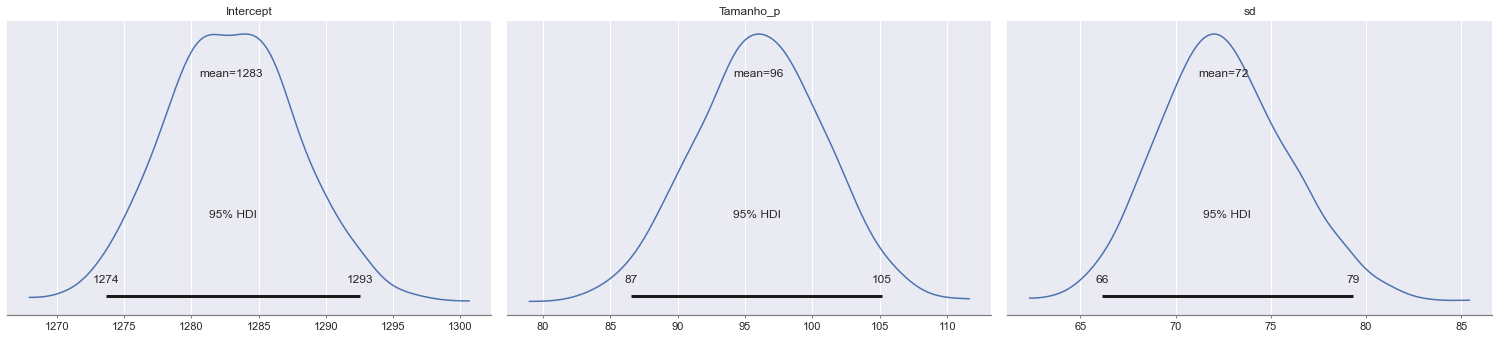

In [172]:
# Representa a posteriori, a média e o intervalo de credibilidade com menor amplitude, denotado por HDI (por simulação MCMC)
pm.plot_posterior(normal_trace, hdi_prob = 0.95);

In [173]:
# Resulta a Máxima a posteriori (MAP), desvio padrão, intervalo de credibilidade HDI...
pm.summary(normal_trace, hdi_prob = 0.95)

mean     sd  hdi_2.5%  hdi_97.5%  mcse_mean  mcse_sd  ess_mean  \
Intercept  1282.925  4.866  1273.622   1292.539      0.072    0.051    4621.0   
Tamanho_p    96.011  4.797    86.562    105.165      0.064    0.045    5571.0   
sd           72.491  3.416    66.118     79.314      0.047    0.033    5331.0   

           ess_sd  ess_bulk  ess_tail  r_hat  
Intercept  4619.0    4614.0    2933.0    1.0  
Tamanho_p  5571.0    5556.0    3144.0    1.0  
sd         5318.0    5294.0    2995.0    1.0

<span style='color:black'>Para geração dos resultados acima, apliquei o método do modelo linear de generalização, ou GLM.<br>E apliquei nesse modelo o método da distribuição normal porque eu aproveitei a análise feita na inferência clássica, onde as amostras se comportavam igual a distribuição normal.<br><br>Na primeira representação tanto o intercepto quanto o meu $\beta{1}$ se comportaram igual a uma distribuição normal.<br>A minha compreensão foi uma vez se comportando igual a forma da distribuição normal, consigo consolidar um pouco mais os números do coeficiente, coluna mean,  e o intervalo de credibilidade para cada uma das variáveis.</span>

<span style='color:black'>Interpretando o resultado sumarizado:<br><ol><li>Intercepto: a média de 1282,925 está contida no intervalo de credibilidade e longe do 0.</li><li>A variável explicativa possui a média de 96,011 e, também, está contida no intervalo de credibilidade, podendo concluir que o tamanho padronizado possui interação com a variável resposta, peso.</li></ol>.</span>

<span style='color:black'><strong>e, neste caso, há diferença nessa relação entre os sexos e entre os grupos etários?</strong></span>

<span style='color:black'>Análise para identificar se a diferença entre os sexos</span>

In [174]:
formula = 'Peso ~ Tamanho_p + Homem'

model_glm = create_model_glm(formula, df_brain)

# Recuperar a máxima posteriori - com a máxima posteriori eu tenho as informações do intercepto e da variável predito - tamanho
map_estimate_glm = pm.find_MAP(model = model_glm)
map_estimate_glm

logp = -1,371.3, ||grad|| = 0.016022: 100%|██████████| 94/94 [00:02<00:00, 42.43it/s]       


{'Intercept': array(1272.77438325),
 'Tamanho_p': array(91.46371209),
 'Homem': array(17.86179383),
 'sd_log__': array(4.26864263),
 'sd': array(71.42462047)}

In [175]:
with model_glm:
    step = pm.NUTS()
    normal_trace = pm.sample(draws = 2000, step = step, start = map_estimate_glm)

Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sd, Homem, Tamanho_p, Intercept]
Sampling 2 chains, 0 divergences: 100%|██████████| 5000/5000 [08:37<00:00,  9.66draws/s] 


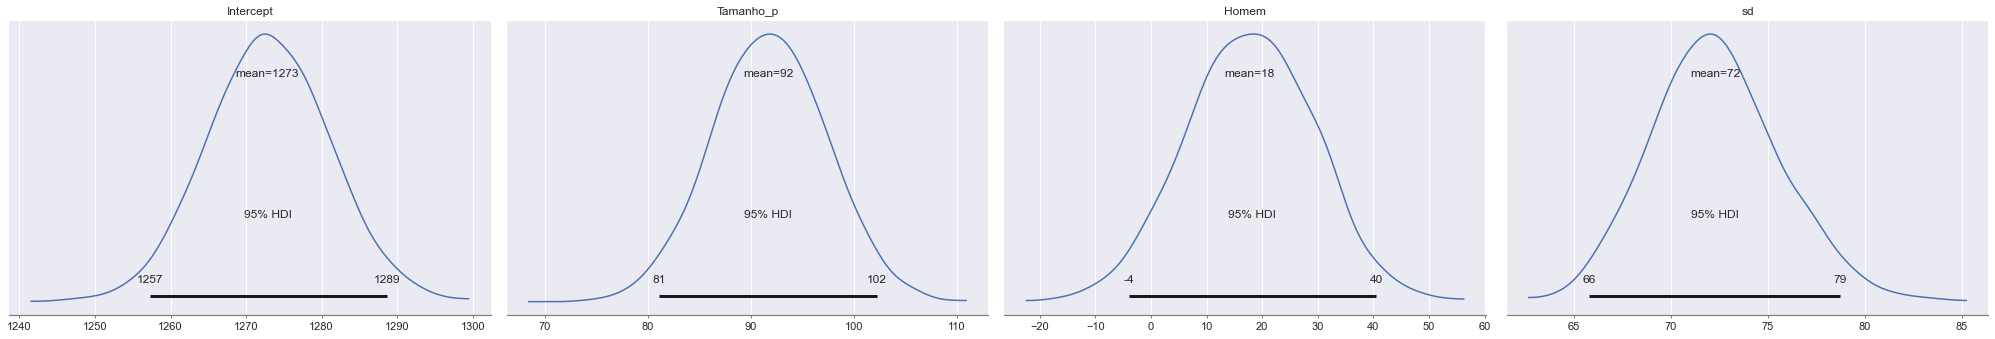

In [176]:
# Representa a posteriori, a média e o intervalo de credibilidade com menor amplitude, denotado por HDI (por simulação MCMC)
pm.plot_posterior(normal_trace, hdi_prob = 0.95);

In [177]:
# Resulta a Máxima a posteriori (MAP), desvio padrão, intervalo de credibilidade HDI...
pm.summary(normal_trace, hdi_prob = 0.95)

mean      sd  hdi_2.5%  hdi_97.5%  mcse_mean  mcse_sd  \
Intercept  1272.819   8.033  1257.228   1288.685      0.180    0.127   
Tamanho_p    91.686   5.451    81.129    102.207      0.113    0.080   
Homem        17.671  11.467    -4.008     40.472      0.256    0.185   
sd           72.284   3.324    65.820     78.711      0.058    0.041   

           ess_mean  ess_sd  ess_bulk  ess_tail  r_hat  
Intercept    1993.0  1993.0    1994.0    2286.0    1.0  
Tamanho_p    2313.0  2313.0    2312.0    2742.0    1.0  
Homem        2001.0  1914.0    2001.0    2178.0    1.0  
sd           3287.0  3271.0    3305.0    2549.0    1.0

<span style='color:black'>Na primeira representação tanto o intercepto quanto o meu $\beta{1}$ e quanto o meu $\beta{2}$ se comportaram igual a uma distribuição normal.<br>Para o atributo Homem, $\beta{2}$ o intervalo de credibilidade é o maior das outras variáveis, perdendo um pouco mais de precisão e dentro do intervalo de credibilidade eu tenho o valor 0, podendo não rejeitar a minha hipótese nula, no entanto o coeficiente do Homem está 17.671</span>

<span style='color:black'>Análise para identificar se a diferença entre os grupos etários</span>

In [178]:
formula = 'Peso ~ Tamanho_p + Acima45'

model_glm = create_model_glm(formula, df_brain)

# Recuperar a máxima posteriori - com a máxima posteriori eu tenho as informações do intercepto e da variável predito - tamanho
map_estimate_glm = pm.find_MAP(model = model_glm)
map_estimate_glm

logp = nan, ||grad|| = 0: 100%|██████████| 62/62 [00:01<00:00, 56.82it/s]                  


{'Intercept': array(16645.30619646),
 'Tamanho_p': array(2430.88608234),
 'Acima45': array(-9709.24828768),
 'sd_log__': array(-521.00467869),
 'sd': array(5.37703667e-227)}

<span style='color:black'>O valor do atributo Acima45 foi um valor negativo bem alto.<br>Isso se deve ao fato de utilizar a minha referência categórica o grupo com a melhor média, isto é, o grupo 0 - Abaixo45.<br>Esse valor do coeficiente foge da predição realizada na inferência clássica.<br><br>Para o final da análise, farei a análise de todas variáveis explicativas, somente, com a padronização na variável quantitativa - Tamanho.</span>

In [179]:
formula = 'Peso ~ Tamanho_p + Homem + Acima45'

model_glm = create_model_glm(formula, df_brain)

# Recuperar a máxima posteriori - com a máxima posteriori eu tenho as informações do intercepto e da variável predito - tamanho
map_estimate_glm = pm.find_MAP(model = model_glm)
map_estimate_glm

logp = -1,375.9, ||grad|| = 0.011075: 100%|██████████| 103/103 [00:01<00:00, 54.93it/s]     


{'Intercept': array(1282.97419962),
 'Tamanho_p': array(89.01208386),
 'Homem': array(22.53921458),
 'Acima45': array(-23.96927085),
 'sd_log__': array(4.25511749),
 'sd': array(70.46509562)}

<span style = 'color:black'>Resultado semelhante dos coeficientes apresentados na inferência clássica.</span>

In [180]:
with model_glm:
    step = pm.NUTS()
    normal_trace = pm.sample(draws = 2000, step = step, start = map_estimate_glm)

Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sd, Acima45, Homem, Tamanho_p, Intercept]
Sampling 2 chains, 0 divergences: 100%|██████████| 5000/5000 [11:30<00:00,  7.24draws/s] 


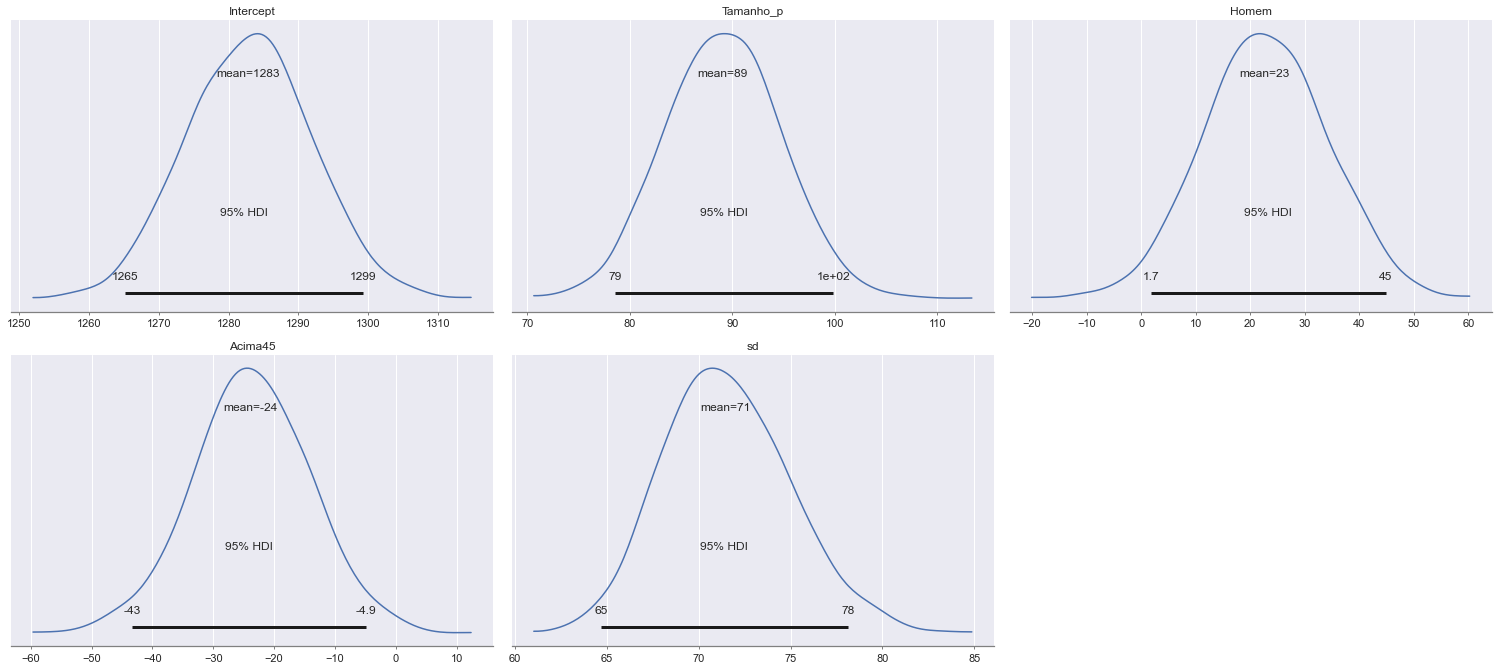

In [181]:
# Representa a posteriori, a média e o intervalo de credibilidade com menor amplitude, denotado por HDI (por simulação MCMC)
pm.plot_posterior(normal_trace, hdi_prob = 0.95);

In [182]:
# Resulta a Máxima a posteriori (MAP), desvio padrão, intervalo de credibilidade HDI...
pm.summary(normal_trace, hdi_prob = 0.95)

mean      sd  hdi_2.5%  hdi_97.5%  mcse_mean  mcse_sd  \
Intercept  1282.811   8.863  1265.192   1299.320      0.178    0.126   
Tamanho_p    89.021   5.593    78.564     99.871      0.106    0.075   
Homem        22.604  11.285     1.736     44.821      0.230    0.163   
Acima45     -23.875   9.561   -43.322     -4.853      0.167    0.119   
sd           71.474   3.423    64.673     78.117      0.059    0.041   

           ess_mean  ess_sd  ess_bulk  ess_tail  r_hat  
Intercept    2478.0  2478.0    2476.0    2398.0    1.0  
Tamanho_p    2808.0  2787.0    2834.0    2331.0    1.0  
Homem        2407.0  2407.0    2408.0    2568.0    1.0  
Acima45      3274.0  3234.0    3274.0    2477.0    1.0  
sd           3423.0  3406.0    3433.0    2309.0    1.0

<span style='color:black'>Resultado parecido ao demonstrado na inferência clássica.<br>Interpretando o modelo:<ol><li>Intercepto: 1282,811 é o valor esperado do peso para tamanho_p, homem e acima45.</li><li>A menor distância entre o intervalo de credibilidade é de $\approx$ 21 do atributo Tamanho, enquanto os intervalos do grupo Acima45 é de $\approx$ 37,5. Isso significa que quanto maior a distância, mas eu estou perdendo a precisão do meu intervalo.</li><li>Para o atributo Homem o valor do coeficiente, 22,604, é a diferença no Peso para o grupo de Homens, pois ele considera o valor 0, Mulheres, sendo a minha categoria referência.</li><li>Ao atributo Acima45 o valor do coeficiente é negativo, -23,875, eu entendi que seja negativo porque a minha categoria referência é 0, grupo abaixo45. A média de Abaixo45 é maior que a média do Acima45, o qual é interpretado no modelo.</li></ol></span>

### Exercício 3

Estime o peso médio do cérebro de homens e de mulheres (pontual e intervalar).

In [183]:
# Método que cria o modelo com priori para distribuição t_student
def create_model_t_student(data, dp, lamb):
    with pm.Model() as model_t:
        mu = pm.Uniform('Média amostral', lower = min(data), upper = max(data))
        s  = pm.HalfNormal('Sigma', sd = dp)
        nu = pm.Exponential('Nu', lamb)
            
        t = pm.StudentT('T - Student', nu = nu, mu = mu, sigma = s, observed = data)
        
        # Anteriormente eu utilizei dessa forma, segue abaixo, e não me pareceu um jeito correto de aplicar a visão bayesiana
        # tanto que eu aproveitei o notebook que a Isis disponibilizou e dei uma lida no arquivo partindo para as definições
        # acimas do t - student
        #t = pm.StudentT('T - Student', nu = len(data) - 1, mu = media, sigma = dp) 
        # Detalhe: cheguei na mesma resposta da inferência clássica usando esse T - Student comentado
    
    return model_t

In [184]:
# Método que cria o modelo com priori para distribuição normal
def create_model_normal(data, dp):
    with pm.Model() as model_n:
        # Definindo priori
        mu = pm.Uniform('Média amostral', lower = min(data), upper = max(data))
        s  = pm.HalfNormal('Sigma', sd = dp)
        # Definindo o likelihood
        no = pm.Normal('Normal', mu = mu, sigma = s, observed = data)
    return model_n

In [185]:
# Função que define intervalos de credibilidade para média, mediana e variância
f_define_confidence_interval = lambda x, y: bayes_mvs(x, y)

<span style='color'>Neste exercício tanto a questão do estimador pontual quanto intervalar, utilizarei 3 formas, as quais pesquisei durante a análise desse exercício: <ul><li>Distribuição Normal</li><li>Distribuição T - Student</li><li>Utilizando o método de Bayes_mvs do scipy e resumidamente, além de devolver a média, mediana e variância, para cada uma delas o método devolve também o intervalo de credibilidade.</li></ul></span>

<span style='color:black'><strong>Premissa para aplicar T - Student no estimador pontual e intervalar</strong> <br><br>Definindo priori e likelihood: <ul><li>Priori:<ul><li>$\mu$: Distribuição Uniforme</li><li>$\sigma$: HalfNormal</li><li>$\nu$ ~ $Exp(\lambda)$ : Distribuição Exponencial</li></ul><br><li>Likelihood<ul><li>$\gamma$ ~ $N(\mu , \sigma^{2}$)</li></ul></li></ul>Tanto para o cenário das mulheres quanto o cenário dos homens, eu aplicarei as duas amostras e respectivamente seus desvios padrões amostrais para realização do cálculo.<br>Detalhe: De acordo com o, <strong> Bayesian Analysis with Python: Introduction to statistical modeling and probabilistic programming using PyMC3 and ArviZ Por Osvaldo Martin</strong> aplicarei o $\nu$ com o valor 1/tamanho da amostra. Ao inverso do que foi proposto na inferência clássica, o parâmetro de normalidade, $\nu$, serve para se aproximar a uma distribuição normal (Gaussiana).</span>

<span style='color:black'><strong>Premissa para aplicar Normal no estimador pontual e intervalar</strong><br><br>Definindo priori e likelihood: <ul><li>Priori:<ul><li>$\mu$: Distribuição Uniforme</li><li>$\sigma$: HalfNormal</li></ul><br><li>Likelihood<ul><li>$\gamma$ ~ $N(\mu , \sigma^{2}$)</li></ul></li></ul>Tanto para o cenário das mulheres quanto o cenário dos homens, eu aplicarei as duas amostras e respectivamente seus desvios padrões amostrais para realização do cálculo.</span>

#### Pontual - Estimação pontual a partir do pymc3 - usando T - Student

In [186]:
lam = 1/tam_n_m

# Chama o método que cria o modelo a partir do pymc3 e devolve o objeto com informações do resultado de t - student
model_t_m = create_model_t_student(mulheres_peso_cerebral, dp_m_a, lam)

# Encontra a máxima posteriori do modelo
map_estimate_t_m = pm.find_MAP(model = model_t_m)

map_arr_t_m = [value for value in map_estimate_t_m.values()]
map_t_m = map_arr_t_m[3]

print(f'A média para o peso cerebral das mulheres: {map_t_m:.4f}')

logp = -640.99, ||grad|| = 11.505: 100%|██████████| 17/17 [00:00<00:00, 44.62it/s]  

A média para o peso cerebral das mulheres: 1218.8521


<span style='color:black'>A média do peso cerebral das mulheres teve uma pequena alteração em comparação com o T Student aplicado na inferência clássica.<br>Os parâmetros foram utilizados da seguinte forma: <ul><li>Conjunto da amostra do grupo do peso cerebral - Mulheres</li><li>dp_m_a = Desvio padrão amostral do grupo Mulheres que eu passei para o HalfNormal.</li><li>Comentado no ínicio da questão, o parâmetro de normalidade insere um valor para aproximar de uma Gaussiana, apliquei 1 / nº tamanho da amostra.</li></ul></span>

In [187]:
lam = 1/tam_n_h

# Chama o método que cria o modelo a partir do pymc3 e devolve o objeto com informações do resultado de t - student
model_t_h = create_model_t_student(homens_peso_cerebral, dp_h_a, lam)

# Encontra a máxima posteriori do modelo
map_estimate_t_h = pm.find_MAP(model = model_t_h)

map_arr_t_h = [value for value in map_estimate_t_h.values()]
map_t_h = map_arr_t_h[3]

print(f'A média para o peso cerebral dos homens: {map_t_h:.4f}')

logp = -835.2, ||grad|| = 6.5597: 100%|██████████| 18/18 [00:00<00:00, 37.44it/s]  


A média para o peso cerebral dos homens: 1329.5553


<span style='color:black'>A média do peso cerebral dos homens teve uma pequena alteração em comparação com o T Student aplicado na inferência clássica.<br>Os parâmetros foram utilizados da seguinte forma: <ul><li>Conjunto da amostra do grupo do peso cerebral - Homens</li><li>dp_h_a = Desvio padrão amostral do grupo Homens que eu passei para o HalfNormal.</li><li>Comentado no ínicio da questão, o parâmetro de normalidade insere um valor para aproximar de uma Gaussiana, apliquei 1 / nº tamanho da amostra.</li></ul></span>

#### Pontual - Estimação pontual a partir do pymc3 - usando Normal

In [188]:
# Chama o método que cria o modelo a partir do pymc3 e devolve o objeto com informações do resultado da normal
model_n_m = create_model_normal(mulheres_peso_cerebral, dp_m_a)

# Encontra a máxima posteriori do modelo
map_estimate_n_m = pm.find_MAP(model = model_n_m)

map_arr_n_m = [value for value in map_estimate_n_m.values()]
map_n_m = map_arr_n_m[2]

print(f'A média para o peso cerebral das mulheres: {map_n_m:.4f}')

logp = -643.76, ||grad|| = 72.893: 100%|██████████| 8/8 [00:00<00:00, 108.37it/s]

A média para o peso cerebral das mulheres: 1219.1456


In [189]:
# Chama o método que cria o modelo a partir do pymc3 e devolve o objeto com informações do resultado da normal
model_n_h = create_model_normal(homens_peso_cerebral, dp_h_a)

# Encontra a máxima posteriori do modelo
map_estimate_n_h = pm.find_MAP(model = model_n_h)

map_arr_n_h = [value for value in map_estimate_n_h.values()]
map_n_h = map_arr_n_h[2]

print(f'A média para o peso cerebral dos homens: {map_n_h:.4f}')

logp = -855.85, ||grad|| = 152.44: 100%|██████████| 10/10 [00:00<00:00, 61.51it/s] 


A média para o peso cerebral dos homens: 1331.8582


#### Pontual - Estimação pontual a partir do método bayes mvs

In [190]:
# Intervalo de credibilidade dos dados do peso cerebral das mullheres
res_mean, res_var, res_std = f_define_confidence_interval(mulheres_peso_cerebral, 0.95)

# Inserir numa lista os intervalos de credibilidade para o grupo de mulheres
lst_int_m = [res_mean[1][0], res_mean[1][1]]

print(f'A média para o peso cerebral das mulheres: {res_mean[0]:.4f}')

A média para o peso cerebral das mulheres: 1219.1456


In [191]:
# Intervalo de confiança dos dados do peso cerebral dos homens
res_mean, res_var, res_std = f_define_confidence_interval(homens_peso_cerebral, 0.95)

# Inserir numa lista os intervalos de credibilidade para o grupo dos homens
lst_int_h = [res_mean[1][0], res_mean[1][1]]

print(f'A média para o peso cerebral dos homens: {res_mean[0]:.4f}')

A média para o peso cerebral dos homens: 1331.8582


#### Intervalar - Usando MCMC para simular observações da posteriori - T Student

<span style='color:black'>Aplicando MCMC no cenário da amostra de peso cerebral das mulheres</span>

Multiprocess sampling (2 chains in 2 jobs)
NUTS: [Nu, Sigma, Média amostral]
Sampling 2 chains, 3 divergences: 100%|██████████| 3000/3000 [03:05<00:00, 16.18draws/s]
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.


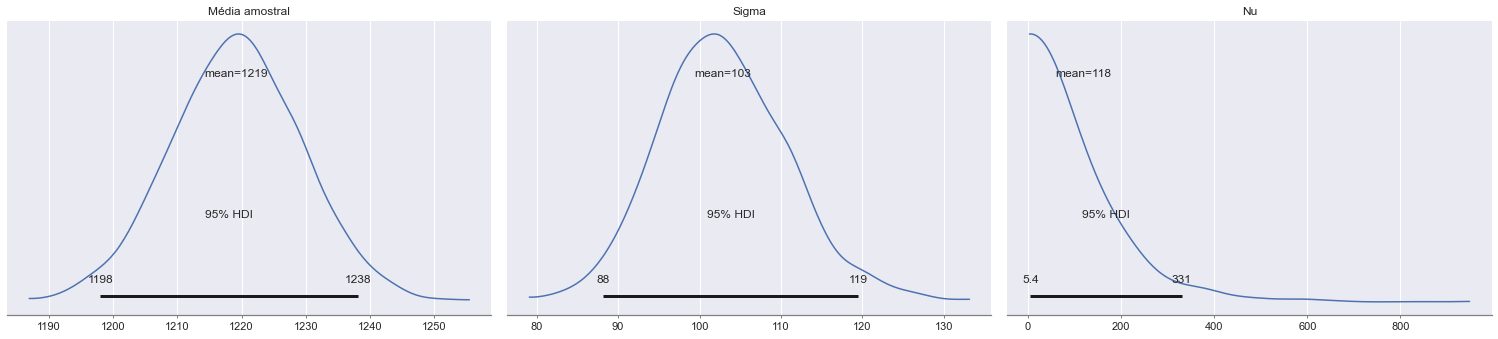

In [192]:
# MCMC para simular observações da posteriori
with model_t_m:
    step = pm.NUTS()
    trace_t_m = pm.sample(draws = 1000, step = step, start = map_estimate_t_m)

# Representa a posteriori, a média e o intervalo de credibilidade com menor amplitude, denotado por HDI (por simulação MCMC) 
pm.plot_posterior(trace_t_m, hdi_prob = 0.95);

In [193]:
# Resulta a Máxima a posteriori (MAP), desvio padrão, intervalo de credibilidade HDI...
pm.summary(trace_t_m, hdi_prob = 0.95)

mean       sd  hdi_2.5%  hdi_97.5%  mcse_mean  mcse_sd  \
Média amostral  1219.083   10.129  1198.024   1238.142      0.245    0.174   
Sigma            102.823    7.949    88.165    119.453      0.218    0.154   
Nu               117.883  105.715     5.393    330.745      2.464    1.798   

                ess_mean  ess_sd  ess_bulk  ess_tail  r_hat  
Média amostral    1703.0  1703.0    1704.0    1204.0    1.0  
Sigma             1328.0  1328.0    1282.0     559.0    1.0  
Nu                1841.0  1729.0    1578.0     866.0    1.0

<span style='color:black'>Na simulação por Monte Carlo via Cadeia de Markov, temos que o intervalo de credibilidade é semelhante ao intervalo de confiança produzido a inferência clássica com T Student.</span>
<span style='color:black'>Interessante das represetações acimas, a média amostral se comportou igual uma distribuição normal, com algumas variações, mas foi semelhante.<br>Tanto para a média, quanto para o sigma e o parâmetro de normalidade, ambos se comportaram como esperado, tendo algumas mudanças, mas no geral os testes foram bons.</span>

<span style='color:black'>Aplicando MCMC no cenário da amostra de peso cerebral dos homens</span>

Multiprocess sampling (2 chains in 2 jobs)
NUTS: [Nu, Sigma, Média amostral]
Sampling 2 chains, 1 divergences: 100%|██████████| 3000/3000 [04:45<00:00, 10.51draws/s]
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.


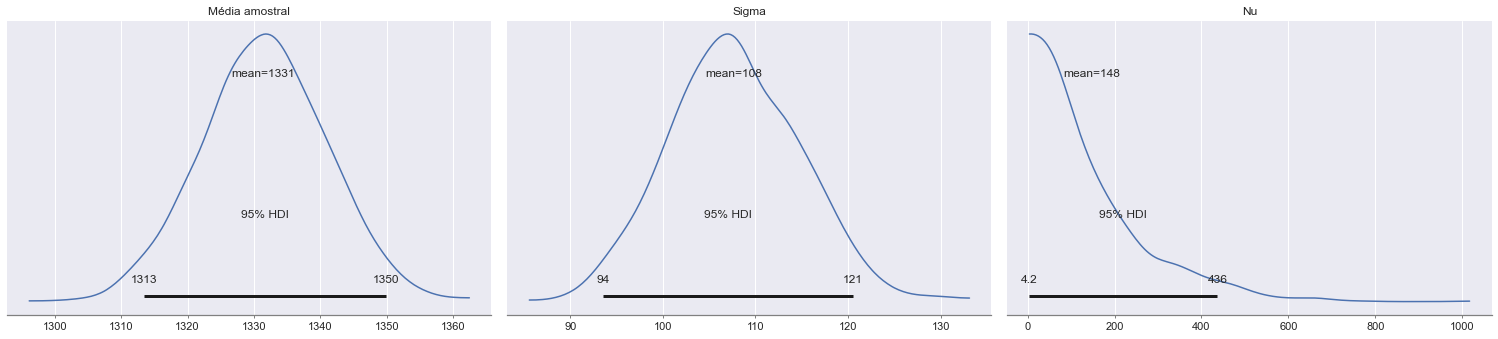

In [194]:
# MCMC para simular observações da posteriori
with model_t_h:
    step = pm.NUTS()
    trace_t_h = pm.sample(draws = 1000, step = step, start = map_estimate_t_h)

# Representa a posteriori, a média e o intervalo de credibilidade com menor amplitude, denotado por HDI (por simulação MCMC) 
pm.plot_posterior(trace_t_h, hdi_prob = 0.95);

In [195]:
# Resulta a Máxima a posteriori (MAP), desvio padrão, intervalo de credibilidade HDI (intervalo e menos amplitude)...
pm.summary(trace_t_h, hdi_prob = 0.95)

mean       sd  hdi_2.5%  hdi_97.5%  mcse_mean  mcse_sd  \
Média amostral  1331.412    9.357  1313.435   1349.948      0.222    0.157   
Sigma            107.626    7.089    93.522    120.556      0.178    0.126   
Nu               147.685  135.112     4.223    436.405      3.510    2.482   

                ess_mean  ess_sd  ess_bulk  ess_tail  r_hat  
Média amostral    1782.0  1782.0    1787.0    1095.0   1.01  
Sigma             1587.0  1587.0    1546.0     841.0   1.00  
Nu                1482.0  1482.0    1171.0     907.0   1.00

<span style='color:black'>A simulação do grupo dos homens seguiu a mesma linha de raciocínio do grupo das Mulheres.</span>

#### Intervalar - Usando MCMC para simular observações da posteriori - Normal

<span style='color:black'>Aplicando MCMC no cenário da amostra de peso cerebral das mulheres</span>

Multiprocess sampling (2 chains in 2 jobs)
NUTS: [Sigma, Média amostral]
Sampling 2 chains, 0 divergences: 100%|██████████| 3000/3000 [01:04<00:00, 46.84draws/s]


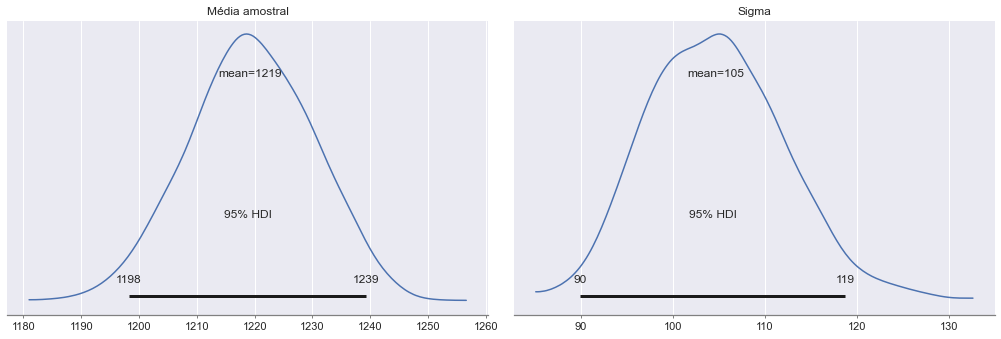

In [196]:
# MCMC para simular observações da posteriori
with model_n_m:
    step = pm.NUTS()
    trace_n_m = pm.sample(draws = 1000, step = step, start = map_estimate_n_m)

# Representa a posteriori, a média e o intervalo de credibilidade com menor amplitude, denotado por HDI (por simulação MCMC) 
pm.plot_posterior(trace_n_m, hdi_prob = 0.95);

In [197]:
# Resulta a Máxima a posteriori (MAP), desvio padrão, intervalo de credibilidade HPI (intervalo e menos amplitude)...
pm.summary(trace_n_m, hdi_prob = 0.95)

mean      sd  hdi_2.5%  hdi_97.5%  mcse_mean  mcse_sd  \
Média amostral  1219.215  10.802  1198.264   1239.363      0.249    0.176   
Sigma            104.675   7.508    89.939    118.678      0.175    0.124   

                ess_mean  ess_sd  ess_bulk  ess_tail  r_hat  
Média amostral    1878.0  1878.0    1876.0    1258.0    1.0  
Sigma             1834.0  1823.0    1840.0    1335.0    1.0

<span style='color:black'>Através da simulação do Monte Carlo via Cadeia de Markov, o intervalo de credibilidade e a média foram próximos ao teste realizado na inferência clássica, porém com pequenas diferenças de valores.<br>Neste caso, eu comparo os valores do teste intervalar da normal da inferência bayesiana com o teste intervalar do T student da inferência clássica.</span>

<span style='color:black'>Aplicando MCMC no cenário da amostra de peso cerebral dos homens</span>

Multiprocess sampling (2 chains in 2 jobs)
NUTS: [Sigma, Média amostral]
Sampling 2 chains, 0 divergences: 100%|██████████| 3000/3000 [01:23<00:00, 35.89draws/s]


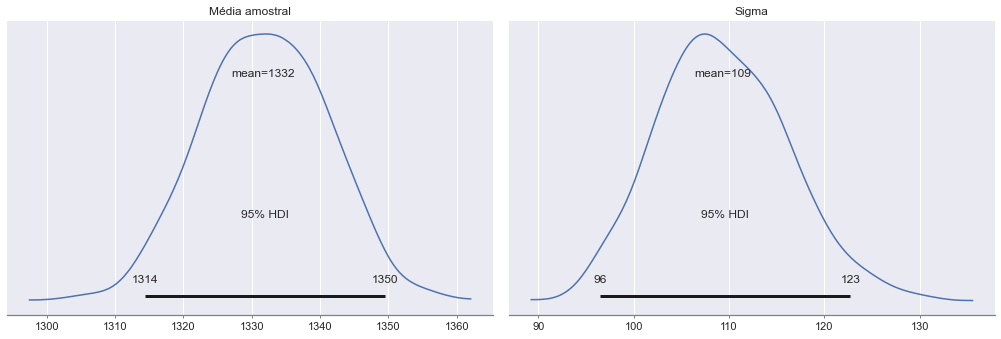

In [198]:
# MCMC para simular observações da posteriori
with model_n_h:
    step = pm.NUTS()
    trace_n_h = pm.sample(draws = 1000, step = step, start = map_estimate_n_h)

# Representa a posteriori, a média e o intervalo de credibilidade com menor amplitude, denotado por HPI (por simulação MCMC) 
pm.plot_posterior(trace_n_h, hdi_prob = 0.95);

In [199]:
# Resulta a Máxima a posteriori (MAP), desvio padrão, intervalo de credibilidade HPI (intervalo e menos amplitude)...
pm.summary(trace_n_h, hdi_prob = 0.95)

mean     sd  hdi_2.5%  hdi_97.5%  mcse_mean  mcse_sd  \
Média amostral  1331.695  9.332  1314.423   1349.538      0.223    0.157   
Sigma            109.302  6.835    96.455    122.724      0.159    0.113   

                ess_mean  ess_sd  ess_bulk  ess_tail  r_hat  
Média amostral    1759.0  1759.0    1768.0    1393.0    1.0  
Sigma             1850.0  1843.0    1843.0    1397.0    1.0

<span style='color:black'>Também no cenário do grupo dos Homens, através da simulação do Monte Carlo via Cadeia de Markov, o intervalo de credibilidade e a média foram próximos ao teste realizado na inferência clássica, porém com pequenas diferenças de valores.<br>Neste caso, eu comparo os valores do teste intervalar da normal da inferência bayesiana com o teste intervalar do T student da inferência clássica.<br>Não usei a mesma lógica para definição do estimador intervalar com a variância desconhecida.</span>

#### Intervalar - Usando o método bayes mvs

In [200]:
print('Para o peso cerebral das mulheres:')
print(f'{ident}O intervalo de credibilidade: {lst_int_m[0]:.4f} e {lst_int_m[1]:.4f}')

Para o peso cerebral das mulheres:
   O intervalo de credibilidade: 1198.8532 e 1239.4381


In [201]:
print('Para o peso cerebral dos homens:')
print(f'{ident}O intervalo de credibilidade: {lst_int_h[0]:.4f} e {lst_int_h[1]:.4f}')

Para o peso cerebral dos homens:
   O intervalo de credibilidade: 1313.2448 e 1350.4716


<span style='color:black'><strong>Conclusão</strong></span><br>
<span style='color:black'>Acredito que eu explorei tudo nessa prova, desde análise descritiva, inferências estatísticas, distribuição normal, ajuste de modelo de regressão linear simples e regressão linear múltipla, estimador pontual e intervalar. Tanto para a inferência clássica onde tive maior domínio sobre o que eu realizava quanto na inferência bayesiana, onde eu precisei ter suporte de links e livros na internet, além do exemplo feito pelos tutores.<br><br>No conceito da inferência clássica, pude ir além na primeira questão, mostrando um pouco do outliers se eles eram ou não influentes e fazendo uma representação das amostras em distribuições normais.<br>Para a segunda questão, eu ajustei o modelo e passei por uma série de normalizações e mesmo que alguma parecesse ideal, olhando somente o modelo. Ter feito a análise de resíduos não só clareou um pouco mais o conceito como pude perceber que nem sempre o modelo "perfeito" é o que explicará os dados. Nessa questão entrou problemas de overffitting, $\beta$ que não tinha nenhuma interação e multicolinearidade.<br>Na terceira questão, além de aplicar a ideia resumida, no geral, consegui demonstrar um método que aplicasse de uma maneira mais geral o cálculo feito, cálculo do estimador da máxima verossimilhança, e aplicar outros cenários na questão intervalar, usando por exemplo o conjunto todo e realizando o cálculo para cada uma das amostras.<br><br>Ao conceito da inferência bayesiana, no final eu consegui entender mais o que é uma priori, likelihood e posteriori, além de saber aplicar o código no pymc3, o qual faz simulação de uma amostra por Monte Carlo via Cadeia de Markov.<br>Superou as minhas expectativas de poder aplicar o modelo glm na segunda questão, embora nessa questão utilizei algumas informações da inferência clássica para resolver.<br>A terceira questão tive mais facilidade, embora no começo utilizei uma forma errônea do "T Student bayesiano".<br><br>Infelizmente, a primeira questão para o mundo bayesiano, eu não consegui fazer. Não tive a ideia correta para aplicar e desenvolver essa questão. Até tentei começar, mas logo vi que estava desviando do ponto, faria o desenvolvimento dessa solução propondo o teste de hipótese igual ou diferente os pesos numa distribuição binomial, no entanto não tive o conhecimento para aplicar e clarear melhor a ideia.<br><br>Tive algumas redudâncias para as respostas, mas eu fiz isso para solucionar de outra forma, pois não queria ficar preso a uma mesma solução. Outro motivador foi: para que eu conseguisse consolidar mais o aprendizado durante este bimestre que foi bastante intenso.<br><br>Prova foi bem coerente e coesa com os estudos feitos durante o bimestre, antes de começá-la não tinha noção do quanto sairia com bastante conteúdo e isso é fruto do auxílio da professora, tutores e de alguns colegas.</span>